In [ ]:
%pip install matplotlib pint h5py

from neural_analysis_pkg.core import NeuralAnalysis
import brpylib #import blackrock library

In [ ]:
project_folder_path = '/Volumes/MannySSD/lmc_project_v2_MINIMAL/Whisker/'  # or LED
analysis = NeuralAnalysis(project_folder_path)
analysis.extract_stimulation_data()

In [ ]:
analysis.recording_results_df
#print the MUA paths for each recording
for idx, row in analysis.recording_results_df.iterrows():
    print("mua_data_path:", row["mua_data_path"])
    print("downsampled_path:", row["downsampled_path"])
    print('---')

In [ ]:
from pathlib import Path

prefix_pairs = [
    ('/home/cresp1el-local/Documents/MATLAB/Data/lmc_project_v2/Whisker/',
     '/Volumes/MannySSD/lmc_project_v2_MINIMAL/Whisker/'),
    ('/home/cresp1el-local/Documents/MATLAB/Data/lmc_project_v2/LED/',
     '/Volumes/MannySSD/lmc_project_v2_MINIMAL/LED/'),
    ('/home/cresp1el-local/Documents/MATLAB/Data/lmc_project_v2/',
     '/Volumes/MannySSD/lmc_project_v2_MINIMAL/'),
]

def rewrite_paths(df, cols):
    for col in cols:
        if col not in df.columns:
            continue
        s = df[col].astype(str)
        for old, new in prefix_pairs:
            mask = s.str.startswith(old)
            s.loc[mask] = s.loc[mask].str.replace(old, new, regex=False)
        # Second pass: fix any entries that lost the Whisker/ segment
        wrong = '/Volumes/MannySSD/lmc_project_v2_MINIMAL/SpikeStuff/'
        right = '/Volumes/MannySSD/lmc_project_v2_MINIMAL/Whisker/SpikeStuff/'
        mask = s.str.startswith(wrong)
        s.loc[mask] = s.loc[mask].str.replace(wrong, right, n=1, regex=False)
        df.loc[:, col] = s
    return df

analysis.recording_results_df = rewrite_paths(
    analysis.recording_results_df,
    ['mua_data_path', 'downsampled_path']
)

# Sanity check
missing = []
for rec, path in zip(analysis.recording_results_df['recording_name'],
                     analysis.recording_results_df['mua_data_path']):
    if not Path(path).exists():
        missing.append((rec, path))
print("Missing MUA entries:", missing)
display(analysis.recording_results_df[['recording_name','mua_data_path']])


In [ ]:
#remove all rows with group name 'Lmc_noopsin' from recording results dataframe
analysis.recording_results_df #show recording results dataframe

In [ ]:
import numpy as np
from pathlib import Path

rec = "lmc_ch_2_3093_rec1"
row = analysis.recording_results_df.query("recording_name == @rec").iloc[0]
mua_path = Path(row["mua_data_path"])

sig = np.load(mua_path, mmap_mode='r')   # ← no memory crash
ch = sig[:, 0]                           # ← only channel 0

print("Channel 0 length:", ch.shape)
print("mean/std:", ch.mean(), ch.std())
print("min/max:", ch.min(), ch.max())

In [ ]:
# Fix paths to SSD
old_roots = [
    '/home/cresp1el-local/Documents/MATLAB/Data/lmc_project_v2/Whisker/',
    '/home/cresp1el-local/Documents/MATLAB/Data/lmc_project_v2/LED/',
    '/home/cresp1el-local/Documents/MATLAB/Data/lmc_project_v2/',
]
new_root = '/Volumes/MannySSD/lmc_project_v2_MINIMAL/'

for col in ['mua_data_path', 'downsampled_path']:
    if col in analysis.recording_results_df.columns:
        s = analysis.recording_results_df[col].astype(str)
        for old in old_roots:
            s = s.str.replace(old, new_root, regex=False)
        analysis.recording_results_df[col] = s

# Helper: firing rate from MUA only
import numpy as np
from scipy.signal import convolve
from pathlib import Path
import pickle

SAMPLING_RATE = 10000
BIN_SIZE = 0.001
GAUSS_WINDOW_MS = 50
GAUSS_SIGMA_MS = 5

def gaussian_kernel(window_ms=GAUSS_WINDOW_MS, sigma_ms=GAUSS_SIGMA_MS, bin_size=BIN_SIZE):
    # convert ms to samples properly: ms / (bin_size * 1000)
    window_samples = int(window_ms / (bin_size * 1000))   # 50ms / (1ms) = 50 samples
    sigma_samples = sigma_ms / (bin_size * 1000)
    half = window_samples // 2
    x = np.arange(-half, half + 1)
    k = np.exp(-0.5 * (x / sigma_samples) ** 2)
    return k / k.sum()

def firing_rate_from_mua(mua_path):
    sig = np.load(mua_path)
    if sig.ndim == 1:
        sig = sig[:, None]
    sig = np.nan_to_num(sig, nan=0.0)

    n_samples, n_ch = sig.shape
    noise = np.median(np.abs(sig), axis=0) / 0.6745

    spikes = sig < (-3 * noise)
    samples_per_bin = int(SAMPLING_RATE * BIN_SIZE)   # 10000 × 0.001 = 10
    n_bins = n_samples // samples_per_bin

    spikes = spikes[:n_bins * samples_per_bin, :].reshape(
        n_bins, samples_per_bin, n_ch
    ).sum(axis=1)

    # convert spikes/bin (1ms) → Hz correctly
    fr_hz = spikes * 1000

    kern = gaussian_kernel()
    return np.vstack([convolve(fr_hz[:, ch], kern, mode='same') for ch in range(n_ch)])

# Run PSTH with a fresh output dir
base_dir = Path('/Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/')  # change run14 to a new run if it already exists
base_dir.mkdir(parents=True, exist_ok=True)

processed_psths_dict = {}

for rec in analysis.recording_results_df['recording_name']:
    row = analysis.recording_results_df.query("recording_name == @rec").iloc[0]
    mua_path = Path(row['mua_data_path'])
    if not mua_path.exists():
        print(f"Skipping {rec}: missing {mua_path}")
        continue
    print("Processing", rec)
    fr = firing_rate_from_mua(mua_path)
    psth = analysis.calculate_psth_pre_post_and_plot_allgoodchannels(
        rec, fr, base_dir=base_dir, pre_trials=30, post_trials=30
    )
    processed_psths_dict[rec] = psth[rec]

# Save dict and df for reuse
with open(base_dir / "processed_psths_dict.pkl", "wb") as f:
    pickle.dump(processed_psths_dict, f)
analysis.recording_results_df.to_pickle(base_dir / "recording_results_df.pkl")
print("Saved dicts to", base_dir)


In [ ]:
analysis.process_ns6_files(project_folder_path, target_channel=35) # 35 is the channel with the whisker analog signal

In [ ]:
import pickle
import numpy as np
from pathlib import Path
import copy

# Load original PSTHs
base_dir = Path('/Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/')
with open(base_dir / "processed_psths_dict.pkl", "rb") as f:
    psths_original = pickle.load(f)

# Make two deep copies so the original stays unchanged
psths_linear = copy.deepcopy(psths_original)
psths_log = copy.deepcopy(psths_original)

# Scaling parameters
linear_scale = 1000.0

def linear_scale_fn(x):
    """Linear rescaling: divide by 10,000."""
    return x / linear_scale

def log_scale_fn(x):
    """Log scaling: log10(1 + x); clips negatives to zero."""
    x_safe = np.maximum(x, 0)   # avoid log of negative
    return np.log10(1 + x_safe)

# Apply scaling to BOTH dicts
for rec in psths_original:
    for ch in psths_original[rec]:
        stim_dict = psths_original[rec][ch].get("Stim_IDs", {})
        for stim in stim_dict:
            entry_original = stim_dict[stim]

            pre = entry_original.get("pre-luciferin_mean_psth")
            post = entry_original.get("post-luciferin_mean_psth")

            # LINEAR
            if isinstance(pre, np.ndarray):
                psths_linear[rec][ch]["Stim_IDs"][stim]["pre-luciferin_mean_psth"] = linear_scale_fn(pre)
            if isinstance(post, np.ndarray):
                psths_linear[rec][ch]["Stim_IDs"][stim]["post-luciferin_mean_psth"] = linear_scale_fn(post)

            # LOG
            if isinstance(pre, np.ndarray):
                psths_log[rec][ch]["Stim_IDs"][stim]["pre-luciferin_mean_psth"] = log_scale_fn(pre)
            if isinstance(post, np.ndarray):
                psths_log[rec][ch]["Stim_IDs"][stim]["post-luciferin_mean_psth"] = log_scale_fn(post)

print("Scaling complete. Original dict remains untouched.")

# Save the two scaled dictionaries
linear_path = base_dir / "processed_psths_dict_scaled_linear.pkl"
log_path = base_dir / "processed_psths_dict_scaled_log.pkl"

with open(linear_path, "wb") as f:
    pickle.dump(psths_linear, f)

with open(log_path, "wb") as f:
    pickle.dump(psths_log, f)

print("Saved (linear):", linear_path)
print("Saved (log):", log_path)

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

# Point to the run folder that has your saved dicts
base_dir = Path('/Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14')  # adjust as needed

with open(base_dir / 'processed_psths_dict.pkl', 'rb') as f:
    processed_psths_dict = pickle.load(f)
recording_results_df = pd.read_pickle(base_dir / 'recording_results_df.pkl')

true_channels_dict = None  # set to your loaded dict if available
stim_ids = ['Stim_1', 'Stim_2', 'Stim_3', 'Stim_4']

def channels_for(rec, stim):
    if true_channels_dict and rec in true_channels_dict and stim in true_channels_dict[rec]:
        return true_channels_dict[rec][stim]
    return list(processed_psths_dict[rec].keys())

def safe_array(x):
    arr = np.array(x)
    if arr.ndim == 0 or arr.size == 0:
        return None
    return arr

# Group recordings by group_name
group_dict = {}
for _, row in recording_results_df.iterrows():
    group_dict.setdefault(row['group_name'], []).append(row['recording_name'])

for group, rec_list in group_dict.items():
    fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharey=True)
    # derive time_axis dynamically from first valid PSTH
    time_axis = None

    for idx, stim in enumerate(stim_ids):
        pre_list, post_list = [], []
        for rec in rec_list:
            if rec not in processed_psths_dict:
                continue
            chan_data = processed_psths_dict[rec]
            for ch in channels_for(rec, stim):
                if ch not in chan_data:
                    continue
                stim_dict = chan_data[ch].get('Stim_IDs', {})
                if stim not in stim_dict:
                    continue
                pre = safe_array(stim_dict[stim].get('pre-luciferin_mean_psth'))
                post = safe_array(stim_dict[stim].get('post-luciferin_mean_psth'))
                if pre is None or post is None:
                    continue
                if time_axis is None:
                    # assume PSTHs span -500..1000 ms over their length
                    T = len(pre)
                    time_axis = np.linspace(-500, 1000, T)
                    mask = (time_axis >= -100) & (time_axis <= 1000)
                # align mask to length
                if len(pre) != len(time_axis):
                    continue
                pre_list.append(pre[mask])
                post_list.append(post[mask])
        ax = axs[idx]
        if pre_list:
            pre_arr = np.vstack(pre_list)
            post_arr = np.vstack(post_list)
            t_clip = time_axis[mask]
            mean_pre = pre_arr.mean(axis=0)
            sem_pre = pre_arr.std(axis=0) / np.sqrt(pre_arr.shape[0])
            mean_post = post_arr.mean(axis=0)
            sem_post = post_arr.std(axis=0) / np.sqrt(post_arr.shape[0])
            ax.plot(t_clip, mean_pre, color='grey', linewidth=1.5, label='Pre')
            ax.fill_between(t_clip, mean_pre - sem_pre, mean_pre + sem_pre, color='grey', alpha=0.2)
            ax.plot(t_clip, mean_post, color='blue', linewidth=1.5, label='Post')
            ax.fill_between(t_clip, mean_post - sem_post, mean_post + sem_post, color='blue', alpha=0.2)
        ax.axvline(0, color='red', linestyle='--', linewidth=1.0)
        ax.set_title(f'{stim}')
        ax.set_xlim(-100, 1000)
        ax.set_xlabel('Time (ms)')
        if idx == 0:
            ax.set_ylabel('Firing rate (a.u.)')
    axs[0].legend()
    out_path = base_dir / f'group_psth_{group}_REGEN.svg'
    fig.savefig(out_path, dpi=300)
    plt.close(fig)
    print(f'Saved {out_path}')


In [59]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

# Base directory holding original and scaled pickles
base_dir = Path('/Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14')

# Load original dict and DataFrame
with open(base_dir / 'processed_psths_dict.pkl', 'rb') as f:
    psth_orig = pickle.load(f)

recording_results_df = pd.read_pickle(base_dir / 'recording_results_df.pkl')

# Create linear- and log-scaled copies
import copy

psth_linear = copy.deepcopy(psth_orig)
psth_log = copy.deepcopy(psth_orig)

# ---- Apply Linear Scaling ----
linear_scale = 1000.0
for rec in psth_linear:
    for ch in psth_linear[rec]:
        for stim in psth_linear[rec][ch]["Stim_IDs"]:
            entry = psth_linear[rec][ch]["Stim_IDs"][stim]
            if isinstance(entry["pre-luciferin_mean_psth"], np.ndarray):
                entry["pre-luciferin_mean_psth"] /= linear_scale
            if isinstance(entry["post-luciferin_mean_psth"], np.ndarray):
                entry["post-luciferin_mean_psth"] /= linear_scale

# ---- Apply Log Scaling ----
def log_scale_fn(x):
    x_safe = np.maximum(x, 0)
    return np.log10(1 + x_safe)

for rec in psth_log:
    for ch in psth_log[rec]:
        for stim in psth_log[rec][ch]["Stim_IDs"]:
            entry = psth_log[rec][ch]["Stim_IDs"][stim]
            if isinstance(entry["pre-luciferin_mean_psth"], np.ndarray):
                entry["pre-luciferin_mean_psth"] = log_scale_fn(entry["pre-luciferin_mean_psth"])
            if isinstance(entry["post-luciferin_mean_psth"], np.ndarray):
                entry["post-luciferin_mean_psth"] = log_scale_fn(entry["post-luciferin_mean_psth"])

# Map labels to dicts
datasets = {
    "ORIGINAL": psth_orig,
    "LINEAR": psth_linear,
    "LOG": psth_log,
}

# Helper
stim_ids = ['Stim_1', 'Stim_2', 'Stim_3', 'Stim_4']

def safe_array(x):
    arr = np.array(x)
    if arr.ndim == 0 or arr.size == 0:
        return None
    return arr

# Group recordings by group_name
group_dict = {}
for _, row in recording_results_df.iterrows():
    group_dict.setdefault(row['group_name'], []).append(row['recording_name'])

# ---- MAIN LOOP: one full plot per dataset version ----
for label, psth_dict in datasets.items():
    print(f"\n⟹ Generating {label} PSTH plots...\n")

    for group, rec_list in group_dict.items():
        fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharey=True)
        time_axis = None

        for idx, stim in enumerate(stim_ids):
            pre_list, post_list = [], []

            for rec in rec_list:
                if rec not in psth_dict:
                    continue
                chan_data = psth_dict[rec]

                for ch in chan_data:
                    stim_dict = chan_data[ch].get('Stim_IDs', {})
                    if stim not in stim_dict:
                        continue

                    pre = safe_array(stim_dict[stim].get('pre-luciferin_mean_psth'))
                    post = safe_array(stim_dict[stim].get('post-luciferin_mean_psth'))
                    if pre is None or post is None:
                        continue

                    if time_axis is None:
                        T = len(pre)
                        time_axis = np.linspace(-500, 1000, T)
                        mask = (time_axis >= -100) & (time_axis <= 1000)

                    if len(pre) != len(time_axis):
                        continue

                    pre_list.append(pre[mask])
                    post_list.append(post[mask])

            ax = axs[idx]
            if pre_list:
                pre_arr = np.vstack(pre_list)
                post_arr = np.vstack(post_list)

                t_clip = time_axis[mask]

                mean_pre = pre_arr.mean(axis=0)
                sem_pre = pre_arr.std(axis=0) / np.sqrt(pre_arr.shape[0])
                mean_post = post_arr.mean(axis=0)
                sem_post = post_arr.std(axis=0) / np.sqrt(post_arr.shape[0])

                ax.plot(t_clip, mean_pre, color='grey', linewidth=1.5, label='Pre')
                ax.fill_between(t_clip, mean_pre - sem_pre, mean_pre + sem_pre, color='grey', alpha=0.2)
                ax.plot(t_clip, mean_post, color='blue', linewidth=1.5, label='Post')
                ax.fill_between(t_clip, mean_post - sem_post, color='blue', alpha=0.2)

            ax.axvline(0, color='red', linestyle='--')
            ax.set_title(f'{stim}')
            ax.set_xlim(-100, 1000)
            ax.set_xlabel("Time (ms)")
            if idx == 0:
                ax.set_ylabel(f"PSTH ({label})")

        axs[0].legend()

        out_path = base_dir / f"group_psth_{group}_{label}.svg"
        fig.savefig(out_path, dpi=300)
        plt.close(fig)
        print(f"Saved {out_path}")


⟹ Generating ORIGINAL PSTH plots...

Saved /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/group_psth_Lmc_opsin_ORIGINAL.svg
Saved /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/group_psth_Lmc_noopsin_ORIGINAL.svg

⟹ Generating LINEAR PSTH plots...

Saved /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/group_psth_Lmc_opsin_LINEAR.svg
Saved /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/group_psth_Lmc_noopsin_LINEAR.svg

⟹ Generating LOG PSTH plots...

Saved /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/group_psth_Lmc_opsin_LOG.svg
Saved /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/group_psth_Lmc_noopsin_LOG.svg


In [62]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

# --------- CONFIGURE WHICH PICKLE TO PLOT ---------
# Choose one: "processed_psths_dict.pkl", "processed_psths_dict_scaled_linear.pkl", "processed_psths_dict_scaled_log.pkl"
label = "LOG"  #LINEAR or LOG  # name used in saved filename
pickle_name = "processed_psths_dict_scaled_linear.pkl"

base_dir = Path('/Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/')
with open(base_dir / pickle_name, "rb") as f:
    psths = pickle.load(f)

recording_results_df = pd.read_pickle(base_dir / 'recording_results_df.pkl')

stim_ids = ['Stim_1', 'Stim_2', 'Stim_3', 'Stim_4']

# --------- HELPERS ---------
def safe_array(x):
    arr = np.array(x)
    if arr.ndim == 0 or arr.size == 0:
        return None
    return arr

# Group recordings by group_name
group_dict = {}
for _, row in recording_results_df.iterrows():
    group_dict.setdefault(row['group_name'], []).append(row['recording_name'])

# --------- MAIN LOOP: CREATE PLOTS FOR EACH GROUP ---------
for group, rec_list in group_dict.items():

    fig, axs = plt.subplots(1, 4, figsize=(22, 5), sharey=False)
    time_axis = None

    for idx, stim in enumerate(stim_ids):
        pre_list, post_list = [], []

        # --- COLLECT ALL PRE/POST PSTHs FOR THIS GROUP/STIM ---
        for rec in rec_list:
            if rec not in psths:
                continue

            chan_data = psths[rec]
            for ch in chan_data:
                stim_dict = chan_data[ch].get("Stim_IDs", {})
                if stim not in stim_dict:
                    continue

                pre = safe_array(stim_dict[stim].get("pre-luciferin_mean_psth"))
                post = safe_array(stim_dict[stim].get("post-luciferin_mean_psth"))
                if pre is None or post is None:
                    continue

                if time_axis is None:
                    T = len(pre)
                    time_axis = np.linspace(-500, 1000, T)
                    mask = (time_axis >= -100) & (time_axis <= 1000)

                pre_list.append(pre[mask])
                post_list.append(post[mask])

        ax = axs[idx]

        if pre_list:
            pre_arr = np.vstack(pre_list)
            post_arr = np.vstack(post_list)

            t_clip = time_axis[mask]

            mean_pre = pre_arr.mean(axis=0)
            sem_pre = pre_arr.std(axis=0) / np.sqrt(pre_arr.shape[0])

            mean_post = post_arr.mean(axis=0)
            sem_post = post_arr.std(axis=0) / np.sqrt(post_arr.shape[0])

            # ---- MAIN PSTH PANEL ----
            ax.plot(t_clip, mean_pre, color='grey', linewidth=1.5, label='Pre')
            ax.fill_between(t_clip, mean_pre - sem_pre, mean_pre + sem_pre,
                            color='grey', alpha=0.20)

            ax.plot(t_clip, mean_post, color='blue', linewidth=1.5, label='Post')
            ax.fill_between(t_clip, mean_post - sem_post, mean_post + sem_post,
                            color='blue', alpha=0.20)

            ax.axvline(0, color='red', linestyle='--')
            ax.set_title(f'{stim}')

            # ---- ΔPSTH = POST – PRE ----
            delta = mean_post - mean_pre

            ax2 = ax.twinx()
            ax2.plot(t_clip, delta, color='purple', linewidth=2.0, alpha=0.8)
            ax2.axhline(0, color='black', linestyle='--', linewidth=0.8)
            ax2.set_yticks([])

            # ---- ΔPEAK (0–50 ms window) ----
            peak_mask = (t_clip >= 0) & (t_clip <= 50)
            peak_pre = mean_pre[peak_mask].max()
            peak_post = mean_post[peak_mask].max()
            delta_peak = peak_post - peak_pre

            ax.text(600, mean_post.max()*0.85,
                    f"ΔPeak = {delta_peak:.2f}",
                    fontsize=10, color='purple')

        ax.set_xlim(-100, 1000)
        ax.set_xlabel("Time (ms)")
        if idx == 0:
            ax.set_ylabel(f"PSTH ({label})")

    axs[0].legend()
    out_path = base_dir / f"group_psth_{group}_{label}_with_delta.svg"
    fig.savefig(out_path, dpi=300)
    plt.close(fig)
    print(f"Saved {out_path}")

Saved /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/group_psth_Lmc_opsin_LOG_with_delta.svg
Saved /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/group_psth_Lmc_noopsin_LOG_with_delta.svg


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

# --------- SELECT WHICH PICKLE TO PLOT ---------
label = "LINEAR"   # options: ORIGINAL, LINEAR, LOG
pickle_name = "processed_psths_dict_scaled_linear.pkl"

base_dir = Path('/Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/')
with open(base_dir / pickle_name, "rb") as f:
    psths = pickle.load(f)

recording_results_df = pd.read_pickle(base_dir / 'recording_results_df.pkl')

stim_ids = ['Stim_1', 'Stim_2', 'Stim_3', 'Stim_4']

# --------- HELPERS ---------
def safe_array(x):
    arr = np.array(x)
    if arr.ndim == 0 or arr.size == 0:
        return None
    return arr

eps = 1e-9  # avoid divide-by-zero

# --------- GROUP RECORDINGS BY GROUP NAME ---------
group_dict = {}
for _, row in recording_results_df.iterrows():
    group_dict.setdefault(row['group_name'], []).append(row['recording_name'])


# --------- MAIN LOOP: CREATE PLOTS PER GROUP ---------
for group, rec_list in group_dict.items():
    print(f"\n=== Processing group: {group} ({label}) ===")

    fig, axs = plt.subplots(4, 1, figsize=(14, 16), sharex=True)
    time_axis = None

    for idx, stim in enumerate(stim_ids):
        ax = axs[idx]

        pre_list, post_list = [], []

        # --- COLLECT PSTHs FOR THIS STIM ---
        for rec in rec_list:
            if rec not in psths:
                continue
            chan_data = psths[rec]

            for ch in chan_data:
                stim_dict = chan_data[ch].get("Stim_IDs", {})
                if stim not in stim_dict:
                    continue

                pre = safe_array(stim_dict[stim].get("pre-luciferin_mean_psth"))
                post = safe_array(stim_dict[stim].get("post-luciferin_mean_psth"))
                if pre is None or post is None:
                    continue

                if time_axis is None:
                    T = len(pre)
                    time_axis = np.linspace(-500, 1000, T)
                    mask = (time_axis >= -100) & (time_axis <= 1000)

                pre_list.append(pre[mask])
                post_list.append(post[mask])

        if not pre_list:
            ax.set_title(f"{stim}: NO DATA")
            continue

        # --- STACK AND AVERAGE ---
        pre_arr = np.vstack(pre_list)
        post_arr = np.vstack(post_list)

        t_clip = time_axis[mask]
        mean_pre = pre_arr.mean(axis=0)
        mean_post = post_arr.mean(axis=0)

        sem_pre = pre_arr.std(axis=0) / np.sqrt(pre_arr.shape[0])
        sem_post = post_arr.std(axis=0) / np.sqrt(post_arr.shape[0])

        # --------- PLOT MAIN PSTH ---------
        ax.plot(t_clip, mean_pre, color='grey', linewidth=1.5, label='Pre')
        ax.fill_between(t_clip, mean_pre - sem_pre, mean_pre + sem_pre,
                        color='grey', alpha=0.2)

        ax.plot(t_clip, mean_post, color='blue', linewidth=1.5, label='Post')
        ax.fill_between(t_clip, mean_post - sem_post, mean_post + sem_post,
                        color='blue', alpha=0.2)

        ax.axvline(0, color='red', linestyle='--')
        ax.set_ylabel(f"{stim} PSTH ({label})")

        # --------- ΔPSTH = POST - PRE ---------
        delta = mean_post - mean_pre
        ax.plot(t_clip, delta, color='purple', linewidth=2, alpha=0.7, label='ΔPSTH')

        # --------- %ΔPSTH = 100*(POST - PRE)/PRE ---------
        pct_change = 100 * delta / (mean_pre + eps)
        ax2 = ax.twinx()
        ax2.plot(t_clip, pct_change, color='green', linewidth=1.5, alpha=0.7)
        ax2.set_yticks([])
        ax2.set_ylabel("%ΔPSTH", color="green")

        # --------- EARLY PEAK (0–50 ms) ---------
        early_mask = (t_clip >= 0) & (t_clip <= 50)
        early_pre = mean_pre[early_mask].max()
        early_post = mean_post[early_mask].max()
        d_peak_early = early_post - early_pre
        pct_early = 100 * d_peak_early / (early_pre + eps)

        # --------- LATE PEAK (200–1000 ms) ---------
        late_mask = (t_clip >= 200) & (t_clip <= 1000)
        late_pre = mean_pre[late_mask].max()
        late_post = mean_post[late_mask].max()
        d_peak_late = late_post - late_pre
        pct_late = 100 * d_peak_late / (late_pre + eps)

        # --------- TEXT ANNOTATION ---------
        ax.text(
            600, mean_post.max()*0.75,
            f"ΔEarly = {d_peak_early:.2f} ({pct_early:.1f}%)\n"
            f"ΔLate  = {d_peak_late:.2f} ({pct_late:.1f}%)",
            fontsize=10,
            color='purple'
        )

    axs[0].legend(loc="upper left")
    axs[-1].set_xlabel("Time (ms)")

    out_path = base_dir / f"group_psth_{group}_{label}_PCTCHANGE.svg"
    fig.savefig(out_path, dpi=300)
    plt.close(fig)
    print(f"Saved {out_path}")


=== Processing group: Lmc_opsin (LINEAR) ===
Saved /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/group_psth_Lmc_opsin_LINEAR_PCTCHANGE.svg

=== Processing group: Lmc_noopsin (LINEAR) ===
Saved /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/group_psth_Lmc_noopsin_LINEAR_PCTCHANGE.svg


In [68]:
%pip install seaborn

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# -------------------
# CONFIG
# -------------------
label = "LINEAR"  # ORIGINAL, LINEAR, LOG
pickle_name = "processed_psths_dict_scaled_linear.pkl"

base_dir = Path('/Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/')
with open(base_dir / pickle_name, "rb") as f:
    psths = pickle.load(f)

recording_results_df = pd.read_pickle(base_dir / "recording_results_df.pkl")

stim_ids = ['Stim_1', 'Stim_2', 'Stim_3', 'Stim_4']
eps = 1e-9

def safe_array(x):
    try:
        arr = np.array(x, dtype=float)
        if arr.ndim == 1 and arr.size > 1:
            return arr
    except:
        pass
    return None


# -------------------
# BUILD PER-CHANNEL EARLY/LATE DATAFRAME
# -------------------
rows = []

for _, rowdf in recording_results_df.iterrows():
    rec = rowdf["recording_name"]
    group = rowdf["group_name"]
    if rec not in psths:
        continue
    
    for ch, ch_data in psths[rec].items():
        for stim in stim_ids:
            if stim not in ch_data["Stim_IDs"]:
                continue

            pre = safe_array(ch_data["Stim_IDs"][stim].get("pre-luciferin_mean_psth"))
            post = safe_array(ch_data["Stim_IDs"][stim].get("post-luciferin_mean_psth"))
            if pre is None or post is None:
                continue

            # Time axis (global PSTH definition)
            T = len(pre)
            time_axis = np.linspace(-500, 1000, T)
            mask = (time_axis >= -100) & (time_axis <= 1000)
            t_clip = time_axis[mask]

            pre_clip = pre[mask]
            post_clip = post[mask]

            # Early and late masks
            early_mask = (t_clip >= 0) & (t_clip <= 50)
            late_mask  = (t_clip >= 200) & (t_clip <= 1000)

            # Compute early & late residuals
            early_pre_peak = pre_clip[early_mask].max()
            early_post_peak = post_clip[early_mask].max()
            delta_early = early_post_peak - early_pre_peak
            delta_early_norm = delta_early / (early_pre_peak + eps)

            late_pre_peak = pre_clip[late_mask].max()
            late_post_peak = post_clip[late_mask].max()
            delta_late = late_post_peak - late_pre_peak
            delta_late_norm = delta_late / (late_pre_peak + eps)

            rows.append({
                "group": group,
                "recording": rec,
                "channel": ch,
                "stim": stim,
                "delta_early": delta_early,
                "delta_late": delta_late,
                "delta_early_norm": delta_early_norm,
                "delta_late_norm": delta_late_norm
            })

df = pd.DataFrame(rows)
display(df.head())
print("Total entries:", len(df))


# -------------------
# MAKE BOXPLOTS — per stim, early vs late
# -------------------
sns.set(style="whitegrid", context="talk")

for stim in stim_ids:
    df_s = df[df["stim"] == stim]

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # ---- Absolute residuals boxplot ----
    sns.boxplot(ax=ax[0], data=df_s, x="group", y="delta_late", color="purple", width=0.4)
    sns.swarmplot(ax=ax[0], data=df_s, x="group", y="delta_late", color="black", alpha=0.6)
    ax[0].set_title(f"{stim} – Late Enhancement (ΔLate)")

    # ---- Normalized residuals boxplot ----
    sns.boxplot(ax=ax[1], data=df_s, x="group", y="delta_late_norm", color="green", width=0.4)
    sns.swarmplot(ax=ax[1], data=df_s, x="group", y="delta_late_norm", color="black", alpha=0.6)
    ax[1].set_title(f"{stim} – Normalized Late Enhancement (ΔLateNorm)")

    fig.suptitle(f"Stimulus {stim} – Channel-Level Enhancement ({label})", fontsize=16)
    fig.tight_layout()

    save_path = base_dir / f"boxplot_{stim}_{label}_LateResiduals.svg"
    fig.savefig(save_path, dpi=300)
    plt.close(fig)
    print(f"Saved boxplot to: {save_path}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


,group,recording,channel,stim,delta_early,delta_late,delta_early_norm,delta_late_norm
0,Lmc_opsin,lmc_ch_2_3093_rec1,Ch_1,Stim_1,30.075512,39.341206,2.090883,2.225069
1,Lmc_opsin,lmc_ch_2_3093_rec1,Ch_1,Stim_2,73.906904,42.720410,0.904591,1.985033
2,Lmc_opsin,lmc_ch_2_3093_rec1,Ch_1,Stim_3,46.363246,38.262681,0.218693,1.257646
3,Lmc_opsin,lmc_ch_2_3093_rec1,Ch_1,Stim_4,64.131876,84.208787,0.305485,3.632921
4,Lmc_opsin,lmc_ch_2_3093_rec1,Ch_2,Stim_1,-18.062759,-41.240321,-0.270046,-0.370557


Total entries: 624
Saved boxplot to: /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/boxplot_Stim_1_LINEAR_LateResiduals.svg
Saved boxplot to: /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/boxplot_Stim_2_LINEAR_LateResiduals.svg
Saved boxplot to: /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/boxplot_Stim_3_LINEAR_LateResiduals.svg
Saved boxplot to: /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/boxplot_Stim_4_LINEAR_LateResiduals.svg


In [69]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# -------------------
# CONFIG
# -------------------
label = "LINEAR"  # options: ORIGINAL, LINEAR, LOG
pickle_name = "processed_psths_dict_scaled_linear.pkl"

base_dir = Path('/Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/')
with open(base_dir / pickle_name, "rb") as f:
    psths = pickle.load(f)

recording_results_df = pd.read_pickle(base_dir / 'recording_results_df.pkl')

stim_ids = ['Stim_1', 'Stim_2', 'Stim_3', 'Stim_4']
eps = 1e-9

def safe_array(x):
    try:
        arr = np.array(x, dtype=float)
        if arr.ndim == 1 and arr.size > 1:
            return arr
    except:
        pass
    return None

# -------------------
# BUILD PER-CHANNEL EARLY/LATE DATAFRAME
# -------------------
rows = []

for _, rowdf in recording_results_df.iterrows():
    rec = rowdf["recording_name"]
    group = rowdf["group_name"]
    if rec not in psths:
        continue
    
    for ch, ch_data in psths[rec].items():
        for stim in stim_ids:
            if stim not in ch_data["Stim_IDs"]:
                continue

            pre = safe_array(ch_data["Stim_IDs"][stim].get("pre-luciferin_mean_psth"))
            post = safe_array(ch_data["Stim_IDs"][stim].get("post-luciferin_mean_psth"))
            if pre is None or post is None:
                continue

            # Time axis
            T = len(pre)
            time_axis = np.linspace(-500, 1000, T)
            mask = (time_axis >= -100) & (time_axis <= 1000)
            t_clip = time_axis[mask]

            pre_clip = pre[mask]
            post_clip = post[mask]

            # Early / Late windows
            early_mask = (t_clip >= 0) & (t_clip <= 50)
            late_mask  = (t_clip >= 200) & (t_clip <= 1000)

            # Compute peaks
            early_pre_peak  = pre_clip[early_mask].max()
            early_post_peak = post_clip[early_mask].max()
            late_pre_peak   = pre_clip[late_mask].max()
            late_post_peak  = post_clip[late_mask].max()

            delta_early = early_post_peak - early_pre_peak
            delta_late  = late_post_peak  - late_pre_peak

            delta_early_norm = delta_early / (early_pre_peak + eps)
            delta_late_norm  = delta_late  / (late_pre_peak  + eps)

            rows.append({
                "group": group,
                "recording": rec,
                "channel": ch,
                "stim": stim,
                "delta_early": delta_early,
                "delta_late": delta_late,
                "delta_early_norm": delta_early_norm,
                "delta_late_norm": delta_late_norm
            })

df = pd.DataFrame(rows)
display(df.head())
print("Total entries:", len(df))


# -------------------
# ONE FIGURE: ALL STIMS + BOTH GROUPS
# -------------------
sns.set(style="whitegrid", context="talk")

fig, ax = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# ========= TOP PANEL: ΔLate (absolute) =========
sns.boxplot(
    data=df, x="stim", y="delta_late", hue="group",
    palette={"Lmc_opsin": "purple", "Lmc_noopsin": "orange"}, ax=ax[0]
)
sns.swarmplot(
    data=df, x="stim", y="delta_late", hue="group",
    dodge=True, color="black", alpha=0.5, ax=ax[0]
)
ax[0].set_title(f"Late Enhancement (Absolute ΔLate) – {label}")
ax[0].set_ylabel("ΔLate = LatePost – LatePre")
ax[0].legend().set_visible(False)  # one legend only

# ========= BOTTOM PANEL: ΔLateNorm (normalized) =========
sns.boxplot(
    data=df, x="stim", y="delta_late_norm", hue="group",
    palette={"Lmc_opsin": "purple", "Lmc_noopsin": "orange"}, ax=ax[1]
)
sns.swarmplot(
    data=df, x="stim", y="delta_late_norm", hue="group",
    dodge=True, color="black", alpha=0.5, ax=ax[1]
)
ax[1].set_title(f"Late Enhancement (Normalized Residual ΔLateNorm) – {label}")
ax[1].set_ylabel("ΔLateNorm = ΔLate / LatePre")
ax[1].set_xlabel("Stimulus")

# Clean up duplicate legends
handles, labels_out = ax[1].get_legend_handles_labels()
ax[1].legend(handles[:2], labels_out[:2], loc="upper right")

fig.tight_layout()

save_path = base_dir / f"ALL_STIMS_{label}_LateEnhancement_Boxplots.svg"
fig.savefig(save_path, dpi=300)
plt.close(fig)
print("Saved combined figure:", save_path)

,group,recording,channel,stim,delta_early,delta_late,delta_early_norm,delta_late_norm
0,Lmc_opsin,lmc_ch_2_3093_rec1,Ch_1,Stim_1,30.075512,39.341206,2.090883,2.225069
1,Lmc_opsin,lmc_ch_2_3093_rec1,Ch_1,Stim_2,73.906904,42.720410,0.904591,1.985033
2,Lmc_opsin,lmc_ch_2_3093_rec1,Ch_1,Stim_3,46.363246,38.262681,0.218693,1.257646
3,Lmc_opsin,lmc_ch_2_3093_rec1,Ch_1,Stim_4,64.131876,84.208787,0.305485,3.632921
4,Lmc_opsin,lmc_ch_2_3093_rec1,Ch_2,Stim_1,-18.062759,-41.240321,-0.270046,-0.370557


Total entries: 624


/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_74047/3462623970.py:106: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_74047/3462623970.py:119: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(


Saved combined figure: /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/ALL_STIMS_LINEAR_LateEnhancement_Boxplots.svg


In [73]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

# ---------------- CONFIG -------------------
label = "LINEAR"  # ORIGINAL, LINEAR, LOG
pickle_name = "processed_psths_dict_scaled_linear.pkl"

base_dir = Path('/Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/')
with open(base_dir / pickle_name, "rb") as f:
    psths = pickle.load(f)

recording_results_df = pd.read_pickle(base_dir / 'recording_results_df.pkl')

stim_ids = ['Stim_1', 'Stim_2', 'Stim_3', 'Stim_4']
groups = ["Lmc_noopsin", "Lmc_opsin"]

# safe array
def safe_array(x):
    try:
        arr = np.array(x, dtype=float)
        if arr.ndim == 1 and arr.size > 1:
            return arr
    except:
        pass
    return None


# ---------------- BUILD MEAN PSTHs PER GROUP -------------------
PSTH = {g: {} for g in groups}

for group in groups:
    for stim in stim_ids:
        pre_list = []
        post_list = []
        time_axis = None

        for _, rowdf in recording_results_df.iterrows():
            if rowdf["group_name"] != group:
                continue

            rec = rowdf["recording_name"]
            if rec not in psths:
                continue

            for ch, ch_data in psths[rec].items():
                stimDict = ch_data["Stim_IDs"]
                if stim not in stimDict:
                    continue

                pre  = safe_array(stimDict[stim].get("pre-luciferin_mean_psth"))
                post = safe_array(stimDict[stim].get("post-luciferin_mean_psth"))
                if pre is None or post is None:
                    continue

                if time_axis is None:
                    T = len(pre)
                    time_axis = np.linspace(-500, 1000, T)
                    mask = (time_axis >= -100) & (time_axis <= 1000)

                pre_list.append(pre[mask])
                post_list.append(post[mask])

        if len(pre_list) == 0:
            continue

        pre_arr = np.vstack(pre_list)
        post_arr = np.vstack(post_list)

        t = time_axis[mask]
        mean_pre  = pre_arr.mean(axis=0)
        sem_pre   = pre_arr.std(axis=0)  / np.sqrt(pre_arr.shape[0])
        mean_post = post_arr.mean(axis=0)
        sem_post  = post_arr.std(axis=0) / np.sqrt(post_arr.shape[0])

        PSTH[group][stim] = {
            "t": t,
            "mean_pre": mean_pre,
            "sem_pre": sem_pre,
            "mean_post": mean_post,
            "sem_post": sem_post
        }


# ---------------- PLOT PSTHS (1 ROW PER GROUP) -------------------

fig, axs = plt.subplots(len(groups), len(stim_ids),
                        figsize=(22, 10), sharey=False)

if len(groups) == 1:
    axs = np.expand_dims(axs, 0)

for gi, group in enumerate(groups):
    for si, stim in enumerate(stim_ids):
        ax = axs[gi, si]

        if stim not in PSTH[group]:
            ax.set_title(f"{stim} (no data)")
            continue

        d = PSTH[group][stim]
        t = d["t"]

        # --- PRE ---
        ax.plot(t, d["mean_pre"], color="grey", linewidth=2)
        ax.fill_between(t, d["mean_pre"] - d["sem_pre"], d["mean_pre"] + d["sem_pre"],
                        color="grey", alpha=0.25)

        # --- POST ---
        ax.plot(t, d["mean_post"], color="blue", linewidth=2)
        ax.fill_between(t, d["mean_post"] - d["sem_post"], d["mean_post"] + d["sem_post"],
                        color="blue", alpha=0.25)

        # --- LATE WINDOW (to reflect ΔLateNorm) ---
        ax.axvspan(200, 1000, color="yellow", alpha=0.12)

        # --- Stimulus onset ---
        ax.axvline(0, color="red", linestyle="--", linewidth=1)

        # Titles/labels
        if gi == 0:
            ax.set_title(f"{stim}")
        if si == 0:
            ax.set_ylabel(f"{group}\nPSTH ({label})")

        ax.set_xlim(-100, 1000)
        ax.set_xlabel("Time (ms)")

plt.tight_layout()
save_path = base_dir / f"PSTH_BY_GROUP_{label}.svg"
fig.savefig(save_path, dpi=300)
plt.close(fig)

print("Saved PSTH figure:", save_path)

Saved PSTH figure: /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/PSTH_BY_GROUP_LINEAR.svg


In [79]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ---------------- CONFIG -------------------
label = "LINEAR"  # ORIGINAL, LINEAR, LOG
pickle_name = "processed_psths_dict_scaled_linear.pkl"

base_dir = Path('/Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/')
with open(base_dir / pickle_name, "rb") as f:
    psths = pickle.load(f)

recording_results_df = pd.read_pickle(base_dir / 'recording_results_df.pkl')

stim_ids = ['Stim_1', 'Stim_2', 'Stim_3', 'Stim_4']
groups = ["Lmc_noopsin", "Lmc_opsin"]
eps = 1e-9

def safe_array(x):
    try:
        arr = np.array(x, dtype=float)
        if arr.ndim == 1 and arr.size > 1:
            return arr
    except:
        pass
    return None


# =============================================================================
# PART 1 — COMPUTE MEAN ± SEM PSTHs FOR EACH GROUP × STIM
# =============================================================================
PSTH = {g: {} for g in groups}

for group in groups:
    for stim in stim_ids:
        pre_list, post_list = [], []
        time_axis = None

        for _, rowdf in recording_results_df.iterrows():
            if rowdf["group_name"] != group:
                continue

            rec = rowdf["recording_name"]
            if rec not in psths:
                continue

            for ch, ch_data in psths[rec].items():
                stimDict = ch_data["Stim_IDs"]
                if stim not in stimDict:
                    continue

                pre  = safe_array(stimDict[stim].get("pre-luciferin_mean_psth"))
                post = safe_array(stimDict[stim].get("post-luciferin_mean_psth"))
                if pre is None or post is None:
                    continue

                if time_axis is None:
                    T = len(pre)
                    time_axis = np.linspace(-500, 1000, T)
                    mask = (time_axis >= -100) & (time_axis <= 1000)

                pre_list.append(pre[mask])
                post_list.append(post[mask])

        if len(pre_list) == 0:
            continue

        pre_arr = np.vstack(pre_list)
        post_arr = np.vstack(post_list)

        t = time_axis[mask]
        mean_pre  = pre_arr.mean(axis=0)
        sem_pre   = pre_arr.std(axis=0)  / np.sqrt(pre_arr.shape[0])
        mean_post = post_arr.mean(axis=0)
        sem_post  = post_arr.std(axis=0) / np.sqrt(post_arr.shape[0])

        PSTH[group][stim] = {
            "t": t,
            "mean_pre": mean_pre,
            "sem_pre": sem_pre,
            "mean_post": mean_post,
            "sem_post": sem_post
        }


# =============================================================================
# PART 2 — PER-CHANNEL ΔLateNorm EXTRACTION
# =============================================================================
late_rows = []

for _, rowdf in recording_results_df.iterrows():
    rec = rowdf["recording_name"]
    group = rowdf["group_name"]
    if rec not in psths:
        continue

    for ch, ch_data in psths[rec].items():
        for stim in stim_ids:
            if stim not in ch_data["Stim_IDs"]:
                continue

            pre = safe_array(ch_data["Stim_IDs"][stim].get("pre-luciferin_mean_psth"))
            post = safe_array(ch_data["Stim_IDs"][stim].get("post-luciferin_mean_psth"))
            if pre is None or post is None:
                continue

            T = len(pre)
            time_axis = np.linspace(-500, 1000, T)
            mask = (time_axis >= -100) & (time_axis <= 1000)
            t_clip = time_axis[mask]

            pre_clip = pre[mask]
            post_clip = post[mask]

            # Late window (matches PSTH shading)
            late_mask = (t_clip >= 200) & (t_clip <= 1000)
            late_pre_peak  = pre_clip[late_mask].max()
            late_post_peak = post_clip[late_mask].max()

            delta_late = late_post_peak - late_pre_peak
            delta_late_norm = delta_late / (late_pre_peak + eps)

            late_rows.append({
                "group": group,
                "recording": rec,
                "channel": ch,
                "stim": stim,
                "delta_late_norm": delta_late_norm,
                "delta_late": delta_late
            })

df_late = pd.DataFrame(late_rows)


# =============================================================================
# PART 3 — NATURE-STYLE FIGURE: 
#  ROW 1: PSTHs (noopsin)
#  ROW 2: PSTHs (opsin)
#  ROW 3: ΔLateNorm boxplots (both groups)
# =============================================================================

sns.set(style="whitegrid", context="talk")

fig = plt.figure(figsize=(22, 14))
gs = fig.add_gridspec(3, 4, height_ratios=[2.5, 2.5, 2.0])

# ---------------- ROW 1: Lmc_noopsin PSTHs ----------------
for si, stim in enumerate(stim_ids):
    ax = fig.add_subplot(gs[0, si])
    group = "Lmc_noopsin"

    if stim in PSTH[group]:
        d = PSTH[group][stim]
        t = d["t"]
        ax.plot(t, d["mean_pre"], color="grey", linewidth=2)
        ax.fill_between(t, d["mean_pre"]-d["sem_pre"], d["mean_pre"]+d["sem_pre"],
                        color="grey", alpha=0.25)

        ax.plot(t, d["mean_post"], color="blue", linewidth=2)
        ax.fill_between(t, d["mean_post"]-d["sem_post"], d["mean_post"]+d["sem_post"],
                        color="blue", alpha=0.25)

        ax.axvspan(200, 1000, color="yellow", alpha=0.12)
        ax.axvline(0, color="red", linestyle="--")

    ax.set_title(f"{stim}")
    if si == 0:
        ax.set_ylabel("Lmc_noopsin\nPSTH")


# ---------------- ROW 2: Lmc_opsin PSTHs ----------------
for si, stim in enumerate(stim_ids):
    ax = fig.add_subplot(gs[1, si])
    group = "Lmc_opsin"

    if stim in PSTH[group]:
        d = PSTH[group][stim]
        t = d["t"]
        ax.plot(t, d["mean_pre"], color="grey", linewidth=2)
        ax.fill_between(t, d["mean_pre"]-d["sem_pre"], d["mean_pre"]+d["sem_pre"],
                        color="grey", alpha=0.25)

        ax.plot(t, d["mean_post"], color="blue", linewidth=2)
        ax.fill_between(t, d["mean_post"]-d["sem_post"], d["mean_post"]+d["sem_post"],
                        color="blue", alpha=0.25)

        ax.axvspan(200, 1000, color="yellow", alpha=0.12)
        ax.axvline(0, color="red", linestyle="--")

    if si == 0:
        ax.set_ylabel("Lmc_opsin\nPSTH")
    ax.set_xlim(-100, 1000)
    ax.set_xlabel("Time (ms)")


# ---------------- ROW 3: ΔLateNorm BOXPLOTS ----------------
for si, stim in enumerate(stim_ids):
    ax = fig.add_subplot(gs[2, si])
    df_s = df_late[df_late["stim"] == stim]

    sns.boxplot(
        data=df_s, x="group", y="delta_late_norm",
        palette={"Lmc_noopsin":"orange", "Lmc_opsin":"purple"}, ax=ax
    )
    sns.swarmplot(
        data=df_s, x="group", y="delta_late_norm",
        dodge=True, color="black", alpha=0.6, ax=ax
    )

    ax.set_title(f"{stim} – ΔLateNorm")
    if si == 0:
        ax.set_ylabel("Normalized Late Enhancement")

fig.tight_layout()
save_path = base_dir / f"FULL_COMPOSITE_PSTH_AND_DELTA_{label}.svg"
fig.savefig(save_path, dpi=300)
plt.close(fig)

print("Saved FULL composite figure:", save_path)

from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd

# df_late must exist already from your composite figure code
# Contains columns: group, recording, channel, stim, delta_late_norm

stim_ids = ['Stim_1', 'Stim_2', 'Stim_3', 'Stim_4']

def p_to_star(p):
    if p < 0.0001: return "****"
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return "ns"

# store p-values
pvals_raw = []
results = []

for stim in stim_ids:
    df_s = df_late[df_late["stim"] == stim]

    a = df_s[df_s.group == "Lmc_noopsin"]["delta_late_norm"].values
    b = df_s[df_s.group == "Lmc_opsin"]["delta_late_norm"].values

    # Mann–Whitney U on ALL CHANNELS (your request)
    stat, p = mannwhitneyu(a, b, alternative='two-sided')
    pvals_raw.append(p)

    results.append({"stim": stim, "U": stat, "p_raw": p})


# ---------------- HOLM–BONFERRONI CORRECTION ----------------
pvals_sorted_idx = np.argsort(pvals_raw)
pvals_corrected = [None]*len(pvals_raw)
m = len(pvals_raw)

for rank, idx in enumerate(pvals_sorted_idx):
    pvals_corrected[idx] = min((m-rank) * pvals_raw[idx], 1.0)


# Attach corrected p-values + stars
for i, r in enumerate(results):
    r["p_corrected"] = pvals_corrected[i]
    r["star"] = p_to_star(pvals_corrected[i])

# Print clean results table
stats_df = pd.DataFrame(results)
display(stats_df)

/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_74047/2025327937.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_74047/2025327937.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_74047/2025327937.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_74047/2025327937.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecat

Saved FULL composite figure: /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/FULL_COMPOSITE_PSTH_AND_DELTA_LINEAR.svg


,stim,U,p_raw,p_corrected,star
0,Stim_1,3176.0,3.436357e-01,3.436357e-01,ns
1,Stim_2,2273.0,2.036627e-02,4.073254e-02,*
2,Stim_3,1340.0,1.209851e-08,3.629552e-08,****
3,Stim_4,948.0,1.095553e-12,4.382211e-12,****


In [80]:
# ============================================================
# FULL COMPOSITE FIGURE — NORMALIZED PSTHs + ΔLateNorm BOXPLOTS
# ============================================================

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ---------------- CONFIG -------------------
label = "LINEAR"  # ORIGINAL, LINEAR, LOG
pickle_name = "processed_psths_dict_scaled_linear.pkl"

base_dir = Path('/Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/')
with open(base_dir / pickle_name, "rb") as f:
    psths = pickle.load(f)

recording_results_df = pd.read_pickle(base_dir / 'recording_results_df.pkl')

stim_ids = ['Stim_1', 'Stim_2', 'Stim_3', 'Stim_4']
groups = ["Lmc_noopsin", "Lmc_opsin"]
eps = 1e-9

def safe_array(x):
    """Convert x to 1D numpy array or return None."""
    try:
        arr = np.array(x, dtype=float)
        return arr if arr.ndim == 1 and arr.size > 1 else None
    except:
        return None


# =============================================================================
# PART 1 — COMPUTE MEAN ± SEM PSTHs FOR EACH GROUP × STIM
# =============================================================================

PSTH = {g: {} for g in groups}

for group in groups:
    for stim in stim_ids:

        pre_list, post_list = [], []
        time_axis = None

        for _, rowdf in recording_results_df.iterrows():
            if rowdf["group_name"] != group:
                continue
            rec = rowdf["recording_name"]

            if rec not in psths:
                continue

            for ch, ch_data in psths[rec].items():
                stimDict = ch_data["Stim_IDs"]

                if stim not in stimDict:
                    continue

                pre  = safe_array(stimDict[stim].get("pre-luciferin_mean_psth"))
                post = safe_array(stimDict[stim].get("post-luciferin_mean_psth"))
                if pre is None or post is None:
                    continue

                if time_axis is None:
                    T = len(pre)
                    time_axis = np.linspace(-500,1000,T)
                    mask = (time_axis >= -100) & (time_axis <= 1000)

                pre_list.append(pre[mask])
                post_list.append(post[mask])

        if len(pre_list)==0:
            continue

        pre_arr  = np.vstack(pre_list)
        post_arr = np.vstack(post_list)

        t = time_axis[mask]
        mean_pre  = pre_arr.mean(axis=0)
        sem_pre   = pre_arr.std(axis=0)/np.sqrt(pre_arr.shape[0])
        mean_post = post_arr.mean(axis=0)
        sem_post  = post_arr.std(axis=0)/np.sqrt(post_arr.shape[0])

        PSTH[group][stim] = {
            "t": t,
            "mean_pre": mean_pre,
            "sem_pre": sem_pre,
            "mean_post": mean_post,
            "sem_post": sem_post
        }


# =============================================================================
# PART 2 — PER-CHANNEL ΔLateNorm EXTRACTION (all channels)
# =============================================================================

late_rows = []

for _, rowdf in recording_results_df.iterrows():
    rec = rowdf["recording_name"]
    group = rowdf["group_name"]

    if rec not in psths:
        continue

    for ch, ch_data in psths[rec].items():
        for stim in stim_ids:

            if stim not in ch_data["Stim_IDs"]:
                continue

            pre  = safe_array(ch_data["Stim_IDs"][stim].get("pre-luciferin_mean_psth"))
            post = safe_array(ch_data["Stim_IDs"][stim].get("post-luciferin_mean_psth"))
            if pre is None or post is None:
                continue

            T = len(pre)
            time_axis = np.linspace(-500,1000,T)
            mask = (time_axis >= -100)&(time_axis<=1000)

            t_clip = time_axis[mask]
            pre_clip  = pre[mask]
            post_clip = post[mask]

            late_mask = (t_clip>=200)&(t_clip<=1000)
            late_pre_peak  = pre_clip[late_mask].max()
            late_post_peak = post_clip[late_mask].max()

            delta_late = late_post_peak - late_pre_peak
            delta_late_norm = delta_late/(late_pre_peak + eps)

            late_rows.append({
                "group": group,
                "recording": rec,
                "channel": ch,
                "stim": stim,
                "delta_late_norm": delta_late_norm,
                "delta_late": delta_late
            })

df_late = pd.DataFrame(late_rows)


# =============================================================================
# PART 3 — NATURE-STYLE FIGURE (Normalized PSTH rows + ΔLateNorm boxplots)
# =============================================================================

sns.set(style="whitegrid", context="talk")
fig = plt.figure(figsize=(22, 14))
gs = fig.add_gridspec(3, 4, height_ratios=[2.5,2.5,2.0])

# -----------------------------
# ROW 1 — NORMALIZED PSTHs (noopsin)
# -----------------------------
for si, stim in enumerate(stim_ids):
    ax = fig.add_subplot(gs[0,si])
    group = "Lmc_noopsin"

    if stim in PSTH[group]:
        d = PSTH[group][stim]

        t = d["t"]
        mean_pre  = d["mean_pre"]
        mean_post = d["mean_post"]
        sem_pre   = d["sem_pre"]
        sem_post  = d["sem_post"]

        # Late normalization (matches ΔLateNorm)
        late_mask = (t>=200)&(t<=1000)
        late_pre_peak = mean_pre[late_mask].max()

        norm_pre  = mean_pre /(late_pre_peak+eps)
        norm_post = mean_post/(late_pre_peak+eps)
        norm_sem_pre  = sem_pre /(late_pre_peak+eps)
        norm_sem_post = sem_post/(late_pre_peak+eps)

        # plot
        ax.plot(t, norm_pre, color="grey", linewidth=2)
        ax.fill_between(t, norm_pre-norm_sem_pre, norm_pre+norm_sem_pre,
                        color="grey", alpha=0.25)

        ax.plot(t, norm_post, color="blue", linewidth=2)
        ax.fill_between(t, norm_post-norm_sem_post, norm_post+norm_sem_post,
                        color="blue", alpha=0.25)

        ax.axvspan(200,1000,color="yellow",alpha=0.12)
        ax.axvline(0,color="red",linestyle="--")

    ax.set_title(stim)
    if si==0:
        ax.set_ylabel("Lmc_noopsin\nNormalized PSTH")


# -----------------------------
# ROW 2 — NORMALIZED PSTHs (opsin)
# -----------------------------
for si, stim in enumerate(stim_ids):
    ax = fig.add_subplot(gs[1,si])
    group = "Lmc_opsin"

    if stim in PSTH[group]:
        d = PSTH[group][stim]

        t = d["t"]
        mean_pre  = d["mean_pre"]
        mean_post = d["mean_post"]
        sem_pre   = d["sem_pre"]
        sem_post  = d["sem_post"]

        # Late normalization
        late_mask = (t>=200)&(t<=1000)
        late_pre_peak = mean_pre[late_mask].max()

        norm_pre  = mean_pre /(late_pre_peak+eps)
        norm_post = mean_post/(late_pre_peak+eps)
        norm_sem_pre  = sem_pre /(late_pre_peak+eps)
        norm_sem_post = sem_post/(late_pre_peak+eps)

        ax.plot(t, norm_pre, color="grey", linewidth=2)
        ax.fill_between(t, norm_pre-norm_sem_pre, norm_pre+norm_sem_pre,
                        color="grey", alpha=0.25)

        ax.plot(t, norm_post, color="blue", linewidth=2)
        ax.fill_between(t, norm_post-norm_sem_post, norm_post+norm_sem_post,
                        color="blue", alpha=0.25)

        ax.axvspan(200,1000,color="yellow",alpha=0.12)
        ax.axvline(0,color="red",linestyle="--")

    if si==0:
        ax.set_ylabel("Lmc_opsin\nNormalized PSTH")

    ax.set_xlim(-100,1000)
    ax.set_xlabel("Time (ms)")


# -----------------------------
# ROW 3 — ΔLateNorm BOXPLOTS (ALL CHANNELS)
# -----------------------------
for si, stim in enumerate(stim_ids):
    ax = fig.add_subplot(gs[2,si])
    df_s = df_late[df_late["stim"]==stim]

    sns.boxplot(data=df_s, 
                x="group", y="delta_late_norm",
                palette={"Lmc_noopsin":"orange","Lmc_opsin":"purple"},
                ax=ax)
    sns.swarmplot(data=df_s, 
                  x="group", y="delta_late_norm",
                  dodge=True, alpha=0.6, color="black",
                  ax=ax)

    ax.set_title(f"{stim} – ΔLateNorm")
    if si==0:
        ax.set_ylabel("ΔLateNorm (all channels)")

fig.tight_layout()

save_path = base_dir/f"FULL_COMPOSITE_normalizedPSTH_and_DeltaLateNorm.svg"
fig.savefig(save_path,dpi=300)
plt.close(fig)

print("Saved full normalized PSTH composite figure:", save_path)

/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_74047/2770581167.py:246: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_s,
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_74047/2770581167.py:246: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_s,
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_74047/2770581167.py:246: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_s,
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_74047/2770581167.py:246: FutureWarning: 

Passing `palette` witho

Saved full normalized PSTH composite figure: /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/FULL_COMPOSITE_normalizedPSTH_and_DeltaLateNorm.svg


In [75]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ---------------- CONFIG -------------------
label = "LINEAR"  # ORIGINAL, LINEAR, LOG
pickle_name = "processed_psths_dict_scaled_linear.pkl"

base_dir = Path('/Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/')
with open(base_dir / pickle_name, "rb") as f:
    psths = pickle.load(f)

recording_results_df = pd.read_pickle(base_dir / 'recording_results_df.pkl')

stim_ids = ['Stim_1', 'Stim_2', 'Stim_3', 'Stim_4']
groups = ["Lmc_noopsin", "Lmc_opsin"]
eps = 1e-9

def safe_array(x):
    try:
        arr = np.array(x, dtype=float)
        if arr.ndim == 1 and arr.size > 1:
            return arr
    except:
        pass
    return None


# =============================================================================
# PART 1 — COMPUTE MEAN ± SEM PSTHs FOR EACH GROUP × STIM
# =============================================================================
PSTH = {g: {} for g in groups}

for group in groups:
    for stim in stim_ids:
        pre_list, post_list = [], []
        time_axis = None

        for _, rowdf in recording_results_df.iterrows():
            if rowdf["group_name"] != group:
                continue

            rec = rowdf["recording_name"]
            if rec not in psths:
                continue

            for ch, ch_data in psths[rec].items():
                stimDict = ch_data["Stim_IDs"]
                if stim not in stimDict:
                    continue

                pre  = safe_array(stimDict[stim].get("pre-luciferin_mean_psth"))
                post = safe_array(stimDict[stim].get("post-luciferin_mean_psth"))
                if pre is None or post is None:
                    continue

                if time_axis is None:
                    T = len(pre)
                    time_axis = np.linspace(-500, 1000, T)
                    mask = (time_axis >= -100) & (time_axis <= 1000)

                pre_list.append(pre[mask])
                post_list.append(post[mask])

        if len(pre_list) == 0:
            continue

        pre_arr = np.vstack(pre_list)
        post_arr = np.vstack(post_list)

        t = time_axis[mask]
        mean_pre  = pre_arr.mean(axis=0)
        sem_pre   = pre_arr.std(axis=0)  / np.sqrt(pre_arr.shape[0])
        mean_post = post_arr.mean(axis=0)
        sem_post  = post_arr.std(axis=0) / np.sqrt(post_arr.shape[0])

        PSTH[group][stim] = {
            "t": t,
            "mean_pre": mean_pre,
            "sem_pre": sem_pre,
            "mean_post": mean_post,
            "sem_post": sem_post
        }


# =============================================================================
# PART 2 — PER-CHANNEL ΔLateNorm EXTRACTION
# =============================================================================
late_rows = []

for _, rowdf in recording_results_df.iterrows():
    rec = rowdf["recording_name"]
    group = rowdf["group_name"]
    if rec not in psths:
        continue

    for ch, ch_data in psths[rec].items():
        for stim in stim_ids:
            if stim not in ch_data["Stim_IDs"]:
                continue

            pre = safe_array(ch_data["Stim_IDs"][stim].get("pre-luciferin_mean_psth"))
            post = safe_array(ch_data["Stim_IDs"][stim].get("post-luciferin_mean_psth"))
            if pre is None or post is None:
                continue

            T = len(pre)
            time_axis = np.linspace(-500, 1000, T)
            mask = (time_axis >= -100) & (time_axis <= 1000)
            t_clip = time_axis[mask]

            pre_clip = pre[mask]
            post_clip = post[mask]

            # Late window
            late_mask = (t_clip >= 200) & (t_clip <= 1000)
            late_pre_peak  = pre_clip[late_mask].max()
            late_post_peak = post_clip[late_mask].max()

            delta_late = late_post_peak - late_pre_peak
            delta_late_norm = delta_late / (late_pre_peak + eps)

            late_rows.append({
                "group": group,
                "recording": rec,
                "channel": ch,
                "stim": stim,
                "delta_late_norm": delta_late_norm,
                "delta_late": delta_late
            })

df_late = pd.DataFrame(late_rows)


# =============================================================================
# PART 3 — NATURE-STYLE FIGURE WITH ROW-WISE SHARED SCALES
# =============================================================================

sns.set(style="whitegrid", context="talk")

fig = plt.figure(figsize=(22, 14))
gs = fig.add_gridspec(3, 4, height_ratios=[2.5, 2.5, 2.0])


# -------------------------------------------------------------
# DETERMINE ROW-WISE Y-LIMITS FOR PSTHs
# -------------------------------------------------------------
# Row 1: Lmc_noopsin
vals_noopsin = []
for stim in stim_ids:
    if stim in PSTH["Lmc_noopsin"]:
        d = PSTH["Lmc_noopsin"][stim]
        vals_noopsin.append(d["mean_pre"])
        vals_noopsin.append(d["mean_post"])
ymin_noopsin = min(map(np.min, vals_noopsin))
ymax_noopsin = max(map(np.max, vals_noopsin))

# Row 2: Lmc_opsin
vals_opsin = []
for stim in stim_ids:
    if stim in PSTH["Lmc_opsin"]:
        d = PSTH["Lmc_opsin"][stim]
        vals_opsin.append(d["mean_pre"])
        vals_opsin.append(d["mean_post"])
ymin_opsin = min(map(np.min, vals_opsin))
ymax_opsin = max(map(np.max, vals_opsin))

# Row 3 (ΔLateNorm)
ymin_box = df_late["delta_late_norm"].min()
ymax_box = df_late["delta_late_norm"].max()


# =============================================================================
# ROW 1 — PSTHs (Lmc_noopsin)
# =============================================================================
for si, stim in enumerate(stim_ids):
    ax = fig.add_subplot(gs[0, si])
    group = "Lmc_noopsin"

    if stim in PSTH[group]:
        d = PSTH[group][stim]
        t = d["t"]

        ax.plot(t, d["mean_pre"],  color="grey", linewidth=2)
        ax.fill_between(t, d["mean_pre"]-d["sem_pre"], d["mean_pre"]+d["sem_pre"],
                        color="grey", alpha=0.25)

        ax.plot(t, d["mean_post"], color="blue", linewidth=2)
        ax.fill_between(t, d["mean_post"]-d["sem_post"], d["mean_post"]+d["sem_post"],
                        color="blue", alpha=0.25)

        ax.axvspan(200, 1000, color="yellow", alpha=0.12)
        ax.axvline(0, color="red", linestyle="--")

    ax.set_ylim(ymin_noopsin, ymax_noopsin)
    ax.set_title(stim)
    if si == 0:
        ax.set_ylabel("Lmc_noopsin\nPSTH")


# =============================================================================
# ROW 2 — PSTHs (Lmc_opsin)
# =============================================================================
for si, stim in enumerate(stim_ids):
    ax = fig.add_subplot(gs[1, si])
    group = "Lmc_opsin"

    if stim in PSTH[group]:
        d = PSTH[group][stim]
        t = d["t"]

        ax.plot(t, d["mean_pre"],  color="grey", linewidth=2)
        ax.fill_between(t, d["mean_pre"]-d["sem_pre"], d["mean_pre"]+d["sem_pre"],
                        color="grey", alpha=0.25)

        ax.plot(t, d["mean_post"], color="blue", linewidth=2)
        ax.fill_between(t, d["mean_post"]-d["sem_post"], d["mean_post"]+d["sem_post"],
                        color="blue", alpha=0.25)

        ax.axvspan(200, 1000, color="yellow", alpha=0.12)
        ax.axvline(0, color="red", linestyle="--")

    ax.set_ylim(ymin_opsin, ymax_opsin)
    if si == 0:
        ax.set_ylabel("Lmc_opsin\nPSTH")
    ax.set_xlim(-100, 1000)
    ax.set_xlabel("Time (ms)")


# =============================================================================
# ROW 3 — BOXPLOTS WITH SHARED Y LIMITS
# =============================================================================
for si, stim in enumerate(stim_ids):
    ax = fig.add_subplot(gs[2, si])
    df_s = df_late[df_late["stim"] == stim]

    sns.boxplot(
        data=df_s, x="group", y="delta_late_norm",
        palette={"Lmc_noopsin":"orange", "Lmc_opsin":"purple"}, ax=ax
    )
    sns.swarmplot(
        data=df_s, x="group", y="delta_late_norm",
        dodge=True, color="black", alpha=0.6, ax=ax
    )

    ax.set_title(f"{stim} – ΔLateNorm")
    ax.set_ylim(ymin_box, ymax_box)
    if si == 0:
        ax.set_ylabel("Normalized Late Enhancement")

fig.tight_layout()
save_path = base_dir / f"FULL_COMPOSITE_PSTH_AND_DELTA_sharedYAxis_{label}.svg"
fig.savefig(save_path, dpi=300)
plt.close(fig)

print("Saved FULL composite figure:", save_path)

/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_74047/842124587.py:240: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_74047/842124587.py:240: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_74047/842124587.py:240: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_74047/842124587.py:240: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

Saved FULL composite figure: /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/FULL_COMPOSITE_PSTH_AND_DELTA_sharedYAxis_LINEAR.svg


In [84]:
# ============================================================
# FULL COMPOSITE FIGURE — NORMALIZED PSTHs + ΔLateNorm BOXPLOTS
# WITH STIM_3 AND STIM_4 MERGED
# ============================================================

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ---------------- CONFIG -------------------
label = "LINEAR"  # ORIGINAL / LINEAR / LOG
pickle_name = "processed_psths_dict_scaled_linear.pkl"

base_dir = Path('/Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/')
with open(base_dir / pickle_name, "rb") as f:
    psths = pickle.load(f)

recording_results_df = pd.read_pickle(base_dir / 'recording_results_df.pkl')

# NEW — merged stim structure
stim_ids = ['Stim_1', 'Stim_2', 'Stim_3_4']
groups = ["Lmc_noopsin", "Lmc_opsin"]
eps = 1e-9

# Maps original stim names into merged categories
stim_merge_map = {
    "Stim_1": "Stim_1",
    "Stim_2": "Stim_2",
    "Stim_3": "Stim_3_4",
    "Stim_4": "Stim_3_4"
}

def safe_array(x):
    """Convert x to 1D numpy array or return None."""
    try:
        arr = np.array(x, dtype=float)
        return arr if arr.ndim == 1 and arr.size > 1 else None
    except:
        return None


# =============================================================================
# PART 1 — COMPUTE MEAN ± SEM NORMALIZED PSTHs FOR each GROUP × MERGED STIM
# =============================================================================

PSTH = {g: {s: {"pre": [], "post": []} for s in stim_ids} for g in groups}

for group in groups:
    for _, rowdf in recording_results_df.iterrows():
        if rowdf["group_name"] != group:
            continue

        rec = rowdf["recording_name"]
        if rec not in psths:
            continue

        for ch, ch_data in psths[rec].items():

            for stim_orig, stim_mapped in stim_merge_map.items():
                if stim_orig not in ch_data["Stim_IDs"]:
                    continue

                pre  = safe_array(ch_data["Stim_IDs"][stim_orig].get("pre-luciferin_mean_psth"))
                post = safe_array(ch_data["Stim_IDs"][stim_orig].get("post-luciferin_mean_psth"))
                if pre is None or post is None:
                    continue

                # mask to -100 to 1000 ms
                T = len(pre)
                time_axis = np.linspace(-500,1000,T)
                mask = (time_axis >= -100) & (time_axis <= 1000)

                PSTH[group][stim_mapped]["pre"].append(pre[mask])
                PSTH[group][stim_mapped]["post"].append(post[mask])


# Now compute mean ± SEM for each group × merged stim
PSTH_stats = {g:{} for g in groups}

for group in groups:
    for stim in stim_ids:
        pre_list  = PSTH[group][stim]["pre"]
        post_list = PSTH[group][stim]["post"]

        if len(pre_list)==0:
            continue

        pre_arr  = np.vstack(pre_list)
        post_arr = np.vstack(post_list)

        t = time_axis[(time_axis >= -100) & (time_axis <= 1000)]
        mean_pre  = pre_arr.mean(axis=0)
        sem_pre   = pre_arr.std(axis=0)/np.sqrt(pre_arr.shape[0])
        mean_post = post_arr.mean(axis=0)
        sem_post  = post_arr.std(axis=0)/np.sqrt(post_arr.shape[0])

        PSTH_stats[group][stim] = {
            "t": t,
            "mean_pre": mean_pre,
            "sem_pre": sem_pre,
            "mean_post": mean_post,
            "sem_post": sem_post
        }


# =============================================================================
# PART 2 — PER-CHANNEL ΔLateNorm EXTRACTION (merged stims)
# =============================================================================

late_rows = []

for _, rowdf in recording_results_df.iterrows():
    rec = rowdf["recording_name"]
    group = rowdf["group_name"]

    if rec not in psths:
        continue

    for ch, ch_data in psths[rec].items():

        for stim_orig, stim_new in stim_merge_map.items():

            if stim_orig not in ch_data["Stim_IDs"]:
                continue

            pre  = safe_array(ch_data["Stim_IDs"][stim_orig].get("pre-luciferin_mean_psth"))
            post = safe_array(ch_data["Stim_IDs"][stim_orig].get("post-luciferin_mean_psth"))
            if pre is None or post is None:
                continue

            T = len(pre)
            time_axis = np.linspace(-500,1000,T)
            mask = (time_axis >= -100) & (time_axis <= 1000)

            t_clip = time_axis[mask]
            pre_clip  = pre[mask]
            post_clip = post[mask]

            late_mask = (t_clip >= 200) & (t_clip <= 1000)
            late_pre_peak  = pre_clip[late_mask].max()
            late_post_peak = post_clip[late_mask].max()

            delta = late_post_peak - late_pre_peak
            delta_norm = delta/(late_pre_peak + eps)

            late_rows.append({
                "group": group,
                "recording": rec,
                "channel": ch,
                "stim": stim_new,   # merged stim label
                "delta_late_norm": delta_norm,
                "delta_late": delta
            })

df_late = pd.DataFrame(late_rows)


# =============================================================================
# PART 3 — FIGURE GENERATION (3 rows × 3 columns)
# =============================================================================

sns.set(style="whitegrid", context="talk")
fig = plt.figure(figsize=(22, 14))
gs = fig.add_gridspec(3, 3, height_ratios=[2.5,2.5,2.0])

# ---- ROW 1 (noopsin normalized PSTHs) ----
for si, stim in enumerate(stim_ids):
    ax = fig.add_subplot(gs[0,si])
    group = "Lmc_noopsin"

    if stim in PSTH_stats[group]:

        d = PSTH_stats[group][stim]
        t = d["t"]
        mean_pre  = d["mean_pre"]
        mean_post = d["mean_post"]
        sem_pre   = d["sem_pre"]
        sem_post  = d["sem_post"]

        # normalization
        late_mask = (t>=200)&(t<=1000)
        late_pre_peak = mean_pre[late_mask].max()

        n_pre  = mean_pre /(late_pre_peak+eps)
        n_post = mean_post/(late_pre_peak+eps)
        n_sem_pre  = sem_pre /(late_pre_peak+eps)
        n_sem_post = sem_post/(late_pre_peak+eps)

        ax.plot(t,n_pre,color="grey",linewidth=2)
        ax.fill_between(t,n_pre-n_sem_pre,n_pre+n_sem_pre,color="grey",alpha=0.25)

        ax.plot(t,n_post,color="blue",linewidth=2)
        ax.fill_between(t,n_post-n_sem_post,n_post+n_sem_post,color="blue",alpha=0.25)

        ax.axvspan(200,1000,color="yellow",alpha=0.12)
        ax.axvline(0,color="red",linestyle="--")

    ax.set_title(stim)
    if si==0:
        ax.set_ylabel("Lmc_noopsin\nNorm PSTH")


# ---- ROW 2 (opsin normalized PSTHs) ----
for si, stim in enumerate(stim_ids):
    ax = fig.add_subplot(gs[1,si])
    group = "Lmc_opsin"

    if stim in PSTH_stats[group]:

        d = PSTH_stats[group][stim]
        t = d["t"]

        mean_pre  = d["mean_pre"]
        mean_post = d["mean_post"]
        sem_pre   = d["sem_pre"]
        sem_post  = d["sem_post"]

        late_mask = (t>=200)&(t<=1000)
        late_pre_peak = mean_pre[late_mask].max()

        n_pre  = mean_pre /(late_pre_peak+eps)
        n_post = mean_post/(late_pre_peak+eps)
        n_sem_pre  = sem_pre /(late_pre_peak+eps)
        n_sem_post = sem_post/(late_pre_peak+eps)

        ax.plot(t,n_pre,color="grey",linewidth=2)
        ax.fill_between(t,n_pre-n_sem_pre,n_pre+n_sem_pre,color="grey",alpha=0.25)

        ax.plot(t,n_post,color="blue",linewidth=2)
        ax.fill_between(t,n_post-n_sem_post,n_post+n_sem_post,color="blue",alpha=0.25)

        ax.axvspan(200,1000,color="yellow",alpha=0.12)
        ax.axvline(0,color="red",linestyle="--")

    if si==0:
        ax.set_ylabel("Lmc_opsin\nNorm PSTH")

    ax.set_xlim(-100,1000)
    ax.set_xlabel("Time (ms)")


# ---- ROW 3 (ΔLateNorm boxplots across merged stims) ----
for si, stim in enumerate(stim_ids):
    ax = fig.add_subplot(gs[2,si])

    df_s = df_late[df_late["stim"]==stim]

    sns.boxplot(data=df_s, x="group", y="delta_late_norm",
                palette={"Lmc_noopsin":"orange","Lmc_opsin":"purple"},
                ax=ax)
    sns.swarmplot(data=df_s, x="group", y="delta_late_norm",
                  dodge=True, color="black", alpha=0.6, ax=ax)

    ax.set_title(f"{stim} – ΔLateNorm")
    if si==0:
        ax.set_ylabel("ΔLateNorm (all channels)")

fig.tight_layout()

save_path = base_dir/"FULL_COMPOSITE_NormalizedPSTH_and_DeltaLateNorm_MERGED_STIM34.svg"
fig.savefig(save_path, dpi=300)
plt.close(fig)

print("Saved merged composite figure:", save_path)

# ============================================================
#   STATS FOR MERGED STIMULI (Stim_1, Stim_2, Stim_3_4)
#   Mann–Whitney U on ALL CHANNELS (matches boxplots)
#   Holm–Bonferroni correction across 3 tests
# ============================================================

from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd

stim_ids_merged = ["Stim_1", "Stim_2", "Stim_3_4"]

def p_to_star(p):
    if p < 0.0001: return "****"
    if p < 0.001:  return "***"
    if p < 0.01:   return "**"
    if p < 0.05:   return "*"
    return "ns"

results = []
pvals_raw = []

for stim in stim_ids_merged:

    df_s = df_late[df_late["stim"] == stim]

    # extract all-channel distributions
    a = df_s[df_s.group == "Lmc_noopsin"]["delta_late_norm"].values
    b = df_s[df_s.group == "Lmc_opsin"]["delta_late_norm"].values

    # Mann–Whitney U test (non-parametric)
    stat, p = mannwhitneyu(a, b, alternative='two-sided')
    pvals_raw.append(p)

    results.append({
        "stim": stim,
        "U": stat,
        "p_raw": p,
        "n_noopsin_channels": len(a),
        "n_opsin_channels": len(b)
    })

# ---------------- HOLM–BONFERRONI CORRECTION ----------------
sorted_idx = np.argsort(pvals_raw)
pvals_corr = [None]*len(pvals_raw)
m = len(pvals_raw)

for rank, idx in enumerate(sorted_idx):
    pvals_corr[idx] = min((m - rank) * pvals_raw[idx], 1.0)

# attach corrected p-values + stars
for i, r in enumerate(results):
    r["p_corrected"] = pvals_corr[i]
    r["significance"] = p_to_star(pvals_corr[i])

# Make a clean stats table
stats_df = pd.DataFrame(results)
display(stats_df)

print("\nDONE — stats for merged stims computed.\n")

# ============================================================
#   STATS FOR MERGED STIMULI (Stim_1, Stim_2, Stim_3_4)
#   Mann–Whitney U on ALL CHANNELS (matches boxplots)
#   Holm–Bonferroni correction across 3 tests
# ============================================================

from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd

stim_ids_merged = ["Stim_1", "Stim_2", "Stim_3_4"]

def p_to_star(p):
    if p < 0.0001: return "****"
    if p < 0.001:  return "***"
    if p < 0.01:   return "**"
    if p < 0.05:   return "*"
    return "ns"

results = []
pvals_raw = []

for stim in stim_ids_merged:

    df_s = df_late[df_late["stim"] == stim]

    # extract all-channel distributions
    a = df_s[df_s.group == "Lmc_noopsin"]["delta_late_norm"].values
    b = df_s[df_s.group == "Lmc_opsin"]["delta_late_norm"].values

    # Mann–Whitney U test (non-parametric)
    stat, p = mannwhitneyu(a, b, alternative='two-sided')
    pvals_raw.append(p)

    results.append({
        "stim": stim,
        "U": stat,
        "p_raw": p,
        "n_noopsin_channels": len(a),
        "n_opsin_channels": len(b)
    })

# ---------------- HOLM–BONFERRONI CORRECTION ----------------
sorted_idx = np.argsort(pvals_raw)
pvals_corr = [None]*len(pvals_raw)
m = len(pvals_raw)

for rank, idx in enumerate(sorted_idx):
    pvals_corr[idx] = min((m - rank) * pvals_raw[idx], 1.0)

# attach corrected p-values + stars
for i, r in enumerate(results):
    r["p_corrected"] = pvals_corr[i]
    r["significance"] = p_to_star(pvals_corr[i])

# Make a clean stats table
stats_df = pd.DataFrame(results)
display(stats_df)

print("\nDONE — stats for merged stims computed.\n")



/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_74047/1648924950.py:251: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_s, x="group", y="delta_late_norm",
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_74047/1648924950.py:251: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_s, x="group", y="delta_late_norm",
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_74047/1648924950.py:251: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_s, x="group", y="delta_late_norm",
/opt/anaconda3/envs/neural_a

Saved merged composite figure: /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/FULL_COMPOSITE_NormalizedPSTH_and_DeltaLateNorm_MERGED_STIM34.svg


,stim,U,p_raw,n_noopsin_channels,n_opsin_channels,p_corrected,significance
0,Stim_1,3176.0,3.436357e-01,62,94,3.436357e-01,ns
1,Stim_2,2273.0,2.036627e-02,62,94,4.073254e-02,*
2,Stim_3_4,4553.0,8.364080e-20,124,188,2.509224e-19,****



DONE — stats for merged stims computed.



,stim,U,p_raw,n_noopsin_channels,n_opsin_channels,p_corrected,significance
0,Stim_1,3176.0,3.436357e-01,62,94,3.436357e-01,ns
1,Stim_2,2273.0,2.036627e-02,62,94,4.073254e-02,*
2,Stim_3_4,4553.0,8.364080e-20,124,188,2.509224e-19,****



DONE — stats for merged stims computed.



In [92]:
# ============================================================
#  FINAL MODULATION PSTH FIGURE (CORRECTED)
#  - Channel-level modulation classification (Stim2 & Stim3_4 only)
#  - ΔLateNorm = max across Stim_2 and Stim_3_4
#  - One modulation label per channel
#  - PSTHs pooled from Stim_2 + Stim_3_4
#  - Correct N (number of unique channels)
# ============================================================

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ---------------- CONFIG -------------------
label = "LINEAR"
pickle_name = "processed_psths_dict_scaled_linear.pkl"
base_dir = Path('/Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/')

with open(base_dir / pickle_name, "rb") as f:
    psths = pickle.load(f)

recording_results_df = pd.read_pickle(base_dir / "recording_results_df.pkl")

eps = 1e-9
groups = ["Lmc_noopsin", "Lmc_opsin"]

# Stim merging
stim_merge_map = {
    "Stim_2": "Stim_2",
    "Stim_3": "Stim_3_4",
    "Stim_4": "Stim_3_4"
}
stim_for_psth = ["Stim_2", "Stim_3_4"]  # PSTHs pooled from these

def safe_array(x):
    try:
        arr = np.array(x, dtype=float)
        return arr if arr.ndim == 1 else None
    except:
        return None

# ============================================================
# PART 1 — Extract ΔLateNorm for Stim_2 and Stim_3_4 (ONLY)
# ============================================================

late_rows = []

for _, rowdf in recording_results_df.iterrows():
    rec   = rowdf["recording_name"]
    group = rowdf["group_name"]

    if rec not in psths:
        continue

    for ch, ch_data in psths[rec].items():

        for stim_orig, stim_new in stim_merge_map.items():

            if stim_orig not in ch_data["Stim_IDs"]:
                continue

            pre  = safe_array(ch_data["Stim_IDs"][stim_orig].get("pre-luciferin_mean_psth"))
            post = safe_array(ch_data["Stim_IDs"][stim_orig].get("post-luciferin_mean_psth"))
            if pre is None or post is None:
                continue

            # clip time
            T = len(pre)
            t = np.linspace(-500, 1000, T)
            mask = (t >= -100) & (t <= 1000)
            t_clip = t[mask]

            pre_clip  = pre[mask]
            post_clip = post[mask]

            # late window
            late_mask = (t_clip >= 200) & (t_clip <= 1000)
            late_pre_peak  = pre_clip[late_mask].max()
            late_post_peak = post_clip[late_mask].max()

            delta = late_post_peak - late_pre_peak
            delta_norm = delta / (late_pre_peak + eps)

            late_rows.append({
                "group": group,
                "recording": rec,
                "channel": ch,
                "stim": stim_new,     # merged label
                "delta_late_norm": delta_norm
            })

df_late = pd.DataFrame(late_rows)


# ============================================================
# PART 2 — Collapse to ONE modulation value per channel
#      ΔLateNorm_channel = max(Stim_2, Stim_3_4)
# ============================================================

df_channel = (
    df_late.groupby(["group","recording","channel"], as_index=False)
           .agg({"delta_late_norm":"max"})
)
df_channel.rename(columns={"delta_late_norm":"delta_mod"}, inplace=True)

# classify channels
def classify(d, thr=0.5):
    if d > thr:
        return "Enhanced"
    elif d < -thr:
        return "Decreased"
    return "No Change"

df_channel["modulation"] = df_channel["delta_mod"].apply(classify)

display(df_channel.head())
print("Counts per modulation group:")
display(df_channel.groupby(["group","modulation"]).size())


# ============================================================
# PART 3 — Collect PSTHs for classification groups (Stim_2 + Stim_3_4 pooled)
# ============================================================

# Data structure
PSTH_mod = {
    g: {"Enhanced":{"pre":[], "post":[]},
        "No Change":{"pre":[], "post":[]},
        "Decreased":{"pre":[], "post":[]}}
    for g in groups
}

# Loop over channels (ONE ENTRY PER CHANNEL)
for _, row in df_channel.iterrows():
    group = row["group"]
    rec   = row["recording"]
    ch    = row["channel"]
    mod   = row["modulation"]

    for stim in stim_for_psth:

        # handle stim_3_4 merging
        stims_to_use = ["Stim_3","Stim_4"] if stim=="Stim_3_4" else ["Stim_2"]

        for s in stims_to_use:

            if s not in psths[rec][ch]["Stim_IDs"]:
                continue

            psth_dict = psths[rec][ch]["Stim_IDs"][s]
            pre  = safe_array(psth_dict.get("pre-luciferin_mean_psth"))
            post = safe_array(psth_dict.get("post-luciferin_mean_psth"))
            if pre is None or post is None:
                continue

            T = len(pre)
            t = np.linspace(-500,1000,T)
            mask = (t >= -100) & (t <= 1000)

            PSTH_mod[group][mod]["pre"].append(pre[mask])
            PSTH_mod[group][mod]["post"].append(post[mask])

t_clip = t[mask]


# ============================================================
# PART 4 — Compute mean ± SEM PSTHs per modulation class
# ============================================================

meanPSTH = {g:{} for g in groups}

for g in groups:
    for mod in ["Enhanced","No Change","Decreased"]:

        pre_list  = PSTH_mod[g][mod]["pre"]
        post_list = PSTH_mod[g][mod]["post"]

        if len(pre_list)==0:
            continue

        pre_arr  = np.vstack(pre_list)
        post_arr = np.vstack(post_list)

        mean_pre  = pre_arr.mean(axis=0)
        sem_pre   = pre_arr.std(axis=0)/np.sqrt(pre_arr.shape[0])

        mean_post = post_arr.mean(axis=0)
        sem_post  = post_arr.std(axis=0)/np.sqrt(post_arr.shape[0])

        # normalize using late PRE peak
        late_mask = (t_clip >= 200) & (t_clip <= 1000)
        late_pre_peak = mean_pre[late_mask].max()

        meanPSTH[g][mod] = {
            "pre": mean_pre/(late_pre_peak+eps),
            "post": mean_post/(late_pre_peak+eps),
            "sem_pre": sem_pre/(late_pre_peak+eps),
            "sem_post": sem_post/(late_pre_peak+eps),
            "n_channels": len(pre_list)
        }


# ============================================================
# PART 5 — PLOT 2 × 3 PSTH figure (Noopsin vs Opsin; Enhanced / NoChange / Decreased)
# ============================================================

sns.set(style="whitegrid", context="talk")
fig, axs = plt.subplots(2,3, figsize=(24,10), sharey=True)

mod_order = ["Enhanced","No Change","Decreased"]

for gi, group in enumerate(groups):
    for mi, mod in enumerate(mod_order):

        ax = axs[gi,mi]

        if mod not in meanPSTH[group]:
            ax.set_title(f"{group}\n{mod}\n(n=0)")
            continue

        d = meanPSTH[group][mod]

        ax.plot(t_clip, d["pre"], color="grey", linewidth=2)
        ax.fill_between(t_clip, d["pre"]-d["sem_pre"], d["pre"]+d["sem_pre"],
                        color="grey", alpha=0.25)

        ax.plot(t_clip, d["post"], color="blue", linewidth=2)
        ax.fill_between(t_clip, d["post"]-d["sem_post"], d["post"]+d["sem_post"],
                        color="blue", alpha=0.25)

        ax.axvspan(200,1000,color="yellow",alpha=0.12)
        ax.axvline(0,color="red",linestyle="--")

        ax.set_xlim(-100,1000)
        ax.set_ylim(0, max(d["post"].max(), d["pre"].max(), 1.2))

        ax.set_title(f"{group}\n{mod} (n={d['n_channels']})")

        if mi==0:
            ax.set_ylabel("Normalized PSTH")
        ax.set_xlabel("Time (ms)")

plt.tight_layout()
save_path = base_dir/"MODULATION_PSTH_FINAL_FIXED.svg"
fig.savefig(save_path,dpi=300)
plt.close(fig)

print("Saved final modulation PSTH figure:", save_path)

,group,recording,channel,delta_mod,modulation
0,Lmc_noopsin,lmc_noch_1_3096_rec1,Ch_1,-0.069210,No Change
1,Lmc_noopsin,lmc_noch_1_3096_rec1,Ch_10,-0.066634,No Change
2,Lmc_noopsin,lmc_noch_1_3096_rec1,Ch_11,0.108595,No Change
3,Lmc_noopsin,lmc_noch_1_3096_rec1,Ch_12,-0.138435,No Change
4,Lmc_noopsin,lmc_noch_1_3096_rec1,Ch_13,0.132364,No Change


Counts per modulation group:


group        modulation
Lmc_noopsin  Enhanced      13
             No Change     49
Lmc_opsin    Enhanced      56
             No Change     38
dtype: int64

Saved final modulation PSTH figure: /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/MODULATION_PSTH_FINAL_FIXED.svg


In [91]:
# ============================================================
#  FINAL MODULATION PSTH FIGURE (CORRECT WITH PROPER N)
#  - Channel classified once using ΔLateNorm from Stim_2 & Stim_3_4
#  - One PSTH per channel = AVERAGE across Stim_2 + Stim_3/Stim_4
#  - N = TRUE NUMBER OF UNIQUE CHANNELS
# ============================================================

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ---------------- LOAD DATA -------------------
label = "LINEAR"
pickle_name = "processed_psths_dict_scaled_linear.pkl"
base_dir = Path('/Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/')

with open(base_dir / pickle_name, "rb") as f:
    psths = pickle.load(f)

recording_results_df = pd.read_pickle(base_dir / "recording_results_df.pkl")

groups = ["Lmc_noopsin", "Lmc_opsin"]
eps = 1e-9

# Only stim2 + strong stim (merged)
stim_merge_map = {
    "Stim_2": "Stim_2",
    "Stim_3": "Stim_3_4",
    "Stim_4": "Stim_3_4",
}

evoked_stims = ["Stim_2", "Stim_3_4"]   # PSTHs pooled from BOTH
all_source_stims = ["Stim_2", "Stim_3", "Stim_4"]

def safe_array(x):
    try:
        arr = np.array(x, dtype=float)
        return arr if arr.ndim == 1 else None
    except:
        return None


# ============================================================
# PART 1 — COMPUTE ΔLateNorm FOR Stim_2 & Stim_3_4 ONLY
# ============================================================

late_rows = []

for _, rowdf in recording_results_df.iterrows():
    rec   = rowdf["recording_name"]
    group = rowdf["group_name"]

    if rec not in psths:
        continue

    for ch, ch_data in psths[rec].items():

        # Try Stim_2 and Stim_3/Stim_4
        for stim_orig in ["Stim_2", "Stim_3", "Stim_4"]:
            if stim_orig not in psths[rec][ch]["Stim_IDs"]:
                continue

            stim_new = stim_merge_map.get(stim_orig, None)
            if stim_new is None:
                continue

            psth_dict = psths[rec][ch]["Stim_IDs"][stim_orig]

            pre  = safe_array(psth_dict.get("pre-luciferin_mean_psth"))
            post = safe_array(psth_dict.get("post-luciferin_mean_psth"))
            if pre is None or post is None:
                continue

            T = len(pre)
            t = np.linspace(-500, 1000, T)
            mask = (t >= -100) & (t <= 1000)
            t_clip = t[mask]

            pre_clip  = pre[mask]
            post_clip = post[mask]

            late_mask = (t_clip >= 200) & (t_clip <= 1000)
            late_pre_peak  = pre_clip[late_mask].max()
            late_post_peak = post_clip[late_mask].max()

            delta = late_post_peak - late_pre_peak
            delta_norm = delta/(late_pre_peak + eps)

            late_rows.append({
                "group": group,
                "recording": rec,
                "channel": ch,
                "stim": stim_new,  # merged
                "delta_late_norm": delta_norm
            })

df_late = pd.DataFrame(late_rows)


# ============================================================
# PART 2 — COLLAPSE TO ONE VALUE PER CHANNEL (MAX ACROSS stims)
# ============================================================

df_channel = (
    df_late.groupby(["group","recording","channel"], as_index=False)
           .agg({"delta_late_norm":"max"})
)

df_channel.rename(columns={"delta_late_norm":"delta_mod"}, inplace=True)

def classify(d, thr=0.5):
    if d > thr: return "Enhanced"
    if d < -thr: return "Decreased"
    return "No Change"

df_channel["modulation"] = df_channel["delta_mod"].apply(classify)

print("Correct modulation counts:")
display(df_channel.groupby(["group","modulation"]).size())


# ============================================================
# PART 3 — BUILD ONE PSTH PER CHANNEL (AVERAGE Stim_2 + Stim_3/4)
# ============================================================

# structure: PSTH_mod[group][mod]["pre"] = [PSTH arrays]
PSTH_mod = {
    g: {"Enhanced":{"pre":[], "post":[]},
        "No Change":{"pre":[], "post":[]},
        "Decreased":{"pre":[], "post":[]}}
    for g in groups
}

for _, row in df_channel.iterrows():
    group = row["group"]
    rec   = row["recording"]
    ch    = row["channel"]
    mod   = row["modulation"]

    pre_list  = []
    post_list = []

    # Collect PSTHs for Stim_2 and Stim_3/4
    for stim_orig in ["Stim_2", "Stim_3", "Stim_4"]:

        if stim_orig not in psths[rec][ch]["Stim_IDs"]:
            continue

        psth_dict = psths[rec][ch]["Stim_IDs"][stim_orig]
        pre  = safe_array(psth_dict.get("pre-luciferin_mean_psth"))
        post = safe_array(psth_dict.get("post-luciferin_mean_psth"))

        if pre is None: continue
        if post is None: continue

        T = len(pre)
        t = np.linspace(-500,1000,T)
        mask = (t >= -100) & (t <= 1000)

        pre_list.append(pre[mask])
        post_list.append(post[mask])

    if len(pre_list)==0:
        continue

    # AVERAGE PSTH ACROSS AVAILABLE stims for this channel
    pre_avg  = np.mean(np.vstack(pre_list), axis=0)
    post_avg = np.mean(np.vstack(post_list), axis=0)

    PSTH_mod[group][mod]["pre"].append(pre_avg)
    PSTH_mod[group][mod]["post"].append(post_avg)

t_clip = t[mask]


# ============================================================
# PART 4 — COMPUTE MEAN ± SEM PSTHs PER modulatio
# ============================================================

meanPSTH = {g:{} for g in groups}

for g in groups:
    for mod in ["Enhanced","No Change","Decreased"]:

        pre_list  = PSTH_mod[g][mod]["pre"]
        post_list = PSTH_mod[g][mod]["post"]

        if len(pre_list)==0:
            continue

        pre_arr  = np.vstack(pre_list)
        post_arr = np.vstack(post_list)

        # Mean & SEM
        mean_pre  = pre_arr.mean(axis=0)
        sem_pre   = pre_arr.std(axis=0)/np.sqrt(pre_arr.shape[0])
        mean_post = post_arr.mean(axis=0)
        sem_post  = post_arr.std(axis=0)/np.sqrt(post_arr.shape[0])

        # Normalization using late PRE peak
        late_mask = (t_clip>=200)&(t_clip<=1000)
        late_pre_peak = mean_pre[late_mask].max()

        meanPSTH[g][mod] = {
            "pre": mean_pre/(late_pre_peak+eps),
            "post": mean_post/(late_pre_peak+eps),
            "sem_pre": sem_pre/(late_pre_peak+eps),
            "sem_post": sem_post/(late_pre_peak+eps),
            "n_channels": len(pre_list)
        }


# ============================================================
# PART 5 — PLOT THE FINAL 2×3 FIGURE
# ============================================================

sns.set(style="whitegrid", context="talk")

fig, axs = plt.subplots(2, 3, figsize=(24,10), sharey=True)

mod_order = ["Enhanced","No Change","Decreased"]

for gi, group in enumerate(groups):
    for mi, mod in enumerate(mod_order):

        ax = axs[gi,mi]

        if mod not in meanPSTH[group]:
            ax.set_title(f"{group}\n{mod}\n(n=0)")
            continue

        d = meanPSTH[group][mod]

        # PRE
        ax.plot(t_clip, d["pre"], color="grey", linewidth=2)
        ax.fill_between(t_clip, d["pre"]-d["sem_pre"], d["pre"]+d["sem_pre"],
                        color="grey", alpha=0.25)

        # POST
        ax.plot(t_clip, d["post"], color="blue", linewidth=2)
        ax.fill_between(t_clip, d["post"]-d["sem_post"], d["post"]+d["sem_post"],
                        color="blue", alpha=0.25)

        ax.axvspan(200,1000,color="yellow",alpha=0.12)
        ax.axvline(0,color="red",linestyle="--")

        ax.set_xlim(-100,1000)
        ax.set_ylim(0, max(1.5, np.max(d["post"])))
        ax.set_title(f"{group}\n{mod} (n={d['n_channels']})")

        if mi==0:
            ax.set_ylabel("Normalized PSTH")
        ax.set_xlabel("Time (ms)")

plt.tight_layout()
save_path = base_dir/"MODULATION_PSTH_FINAL_CORRECT_CHANNEL_N.svg"
fig.savefig(save_path,dpi=300)
plt.close(fig)

print("Saved final, correct modulation PSTH figure:", save_path)

Correct modulation counts:


group        modulation
Lmc_noopsin  Enhanced      13
             No Change     49
Lmc_opsin    Enhanced      56
             No Change     38
dtype: int64

Saved final, correct modulation PSTH figure: /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run14/MODULATION_PSTH_FINAL_CORRECT_CHANNEL_N.svg


FINDING THE INTERACTION EFFECT

In [93]:
# ============================================================
#  EXTRACT ALL THREE MODULATION DEFINITIONS PER CHANNEL
#  (Stim_3_4 only, Stim_2 only, Averaged Stim2+Stim3/4)
#  Creates: df_mod_stim34, df_mod_stim2, df_mod_avg
# ============================================================

import numpy as np
import pandas as pd

eps = 1e-9
late_low  = 200
late_high = 1000

def compute_late_metrics(pre, post, t):
    """Given pre- and post-PSTH arrays and time axis, extract late peaks + deltas."""
    mask = (t >= -100) & (t <= 1000)
    t_clip = t[mask]
    late_mask = (t_clip >= late_low) & (t_clip <= late_high)

    pre_late  = pre[mask][late_mask]
    post_late = post[mask][late_mask]

    if len(pre_late)==0 or len(post_late)==0:
        return None

    pre_peak  = pre_late.max()
    post_peak = post_late.max()

    delta      = post_peak - pre_peak
    delta_norm = delta / (pre_peak + eps)

    return pre_peak, post_peak, delta, delta_norm


def classify(delta_norm, thr=0.1):
    if delta_norm > thr:
        return "Enhanced"
    elif delta_norm < -thr:
        return "Decreased"
    return "No Change"



# --------------------------------------------------------
# Helper to extract PRE/PST PSTHs for a single stim
# --------------------------------------------------------
def get_psth_for_stim(psths, rec, ch, stim):
    if stim not in psths[rec][ch]["Stim_IDs"]:
        return None
    d = psths[rec][ch]["Stim_IDs"][stim]
    pre  = np.array(d.get("pre-luciferin_mean_psth"))
    post = np.array(d.get("post-luciferin_mean_psth"))
    if pre.ndim != 1 or post.ndim != 1:
        return None
    t = np.linspace(-500, 1000, len(pre))
    return pre, post, t


# --------------------------------------------------------
# NOW BUILD THE THREE DATASETS:
#   1. Stim_3_4 only
#   2. Stim_2 only
#   3. Averaged across Stim_2 + Stim_3/4
# --------------------------------------------------------

rows34 = []
rows2  = []
rowsAvg = []

for _, row in df_channel.iterrows():
    group = row["group"]
    rec   = row["recording"]
    ch    = row["channel"]

    # ---- Stim 3_4 PSTHs (Stim_3 or Stim_4)
    stim34_prepost = []
    for s in ["Stim_3","Stim_4"]:
        out = get_psth_for_stim(psths, rec, ch, s)
        if out: stim34_prepost.append(out)

    if stim34_prepost:
        # average if both Stim3 and Stim4 exist
        pre_list  = [x[0] for x in stim34_prepost]
        post_list = [x[1] for x in stim34_prepost]
        t         = stim34_prepost[0][2]

        pre34  = np.mean(np.vstack(pre_list), axis=0)
        post34 = np.mean(np.vstack(post_list), axis=0)

        m = compute_late_metrics(pre34, post34, t)
        if m:
            pre_peak, post_peak, delta, delta_norm = m
            rows34.append({
                "group": group,
                "recording": rec,
                "channel": ch,
                "pre_peak": pre_peak,
                "post_peak": post_peak,
                "delta": delta,
                "delta_norm": delta_norm,
                "modulation": classify(delta_norm)
            })


    # ---- Stim 2 PSTH alone
    out2 = get_psth_for_stim(psths, rec, ch, "Stim_2")
    if out2:
        pre2, post2, t2 = out2
        m2 = compute_late_metrics(pre2, post2, t2)
        if m2:
            pre_peak, post_peak, delta, delta_norm = m2
            rows2.append({
                "group": group,
                "recording": rec,
                "channel": ch,
                "pre_peak": pre_peak,
                "post_peak": post_peak,
                "delta": delta,
                "delta_norm": delta_norm,
                "modulation": classify(delta_norm)
            })


    # ---- AVERAGED Stim2 + Stim3_4 PSTH (final modality)
    psth_list_pre  = []
    psth_list_post = []
    tavg = None

    # include stim2
    if out2:
        psth_list_pre.append(pre2)
        psth_list_post.append(post2)
        tavg = t2

    # include stim3 & stim4
    for s in ["Stim_3","Stim_4"]:
        out = get_psth_for_stim(psths, rec, ch, s)
        if out:
            pre,post,_t = out
            psth_list_pre.append(pre)
            psth_list_post.append(post)
            if tavg is None:
                tavg = _t

    if psth_list_pre:
        preAvg  = np.mean(np.vstack(psth_list_pre), axis=0)
        postAvg = np.mean(np.vstack(psth_list_post), axis=0)

        mA = compute_late_metrics(preAvg, postAvg, tavg)
        if mA:
            pre_peak, post_peak, delta, delta_norm = mA
            rowsAvg.append({
                "group": group,
                "recording": rec,
                "channel": ch,
                "pre_peak": pre_peak,
                "post_peak": post_peak,
                "delta": delta,
                "delta_norm": delta_norm,
                "modulation": classify(delta_norm)
            })


# Convert to dataframes
df_mod_stim34 = pd.DataFrame(rows34)
df_mod_stim2  = pd.DataFrame(rows2)
df_mod_avg    = pd.DataFrame(rowsAvg)

print("\n=== Stim_3_4 ONLY ===")
display(df_mod_stim34.groupby(["group","modulation"]).size())

print("\n=== Stim_2 ONLY ===")
display(df_mod_stim2.groupby(["group","modulation"]).size())

print("\n=== AVERAGED (Stim_2 + Stim_3_4) ===")
display(df_mod_avg.groupby(["group","modulation"]).size())


=== Stim_3_4 ONLY ===


group        modulation
Lmc_noopsin  Decreased     29
             Enhanced      14
             No Change     19
Lmc_opsin    Decreased     13
             Enhanced      74
             No Change      7
dtype: int64


=== Stim_2 ONLY ===


group        modulation
Lmc_noopsin  Decreased     14
             Enhanced      30
             No Change     18
Lmc_opsin    Decreased     16
             Enhanced      59
             No Change     19
dtype: int64


=== AVERAGED (Stim_2 + Stim_3_4) ===


group        modulation
Lmc_noopsin  Decreased     30
             Enhanced      11
             No Change     21
Lmc_opsin    Decreased     17
             Enhanced      70
             No Change      7
dtype: int64

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 9.1 MB/s eta 0:00:0000:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 19.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


ANALYSIS FOR: Stim_3_4 only



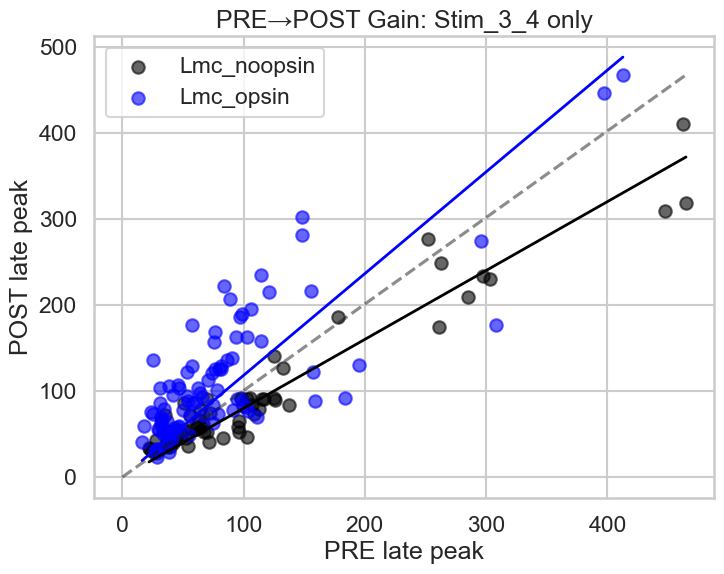


Model comparison:

           label  n_points  slope_mul  \
0  Stim_3_4 only       156    0.96047   

                                slope_mul_CI      mul_AIC  intercept_add  \
0  [[0.897809920432671, 1.0231308422944103]]  1664.938135      12.477516   

                             intercept_add_CI      add_AIC  
0  [[4.7627218503962645, 20.192310418412436]]  1656.544274  


ANALYSIS FOR: Stim_2 only



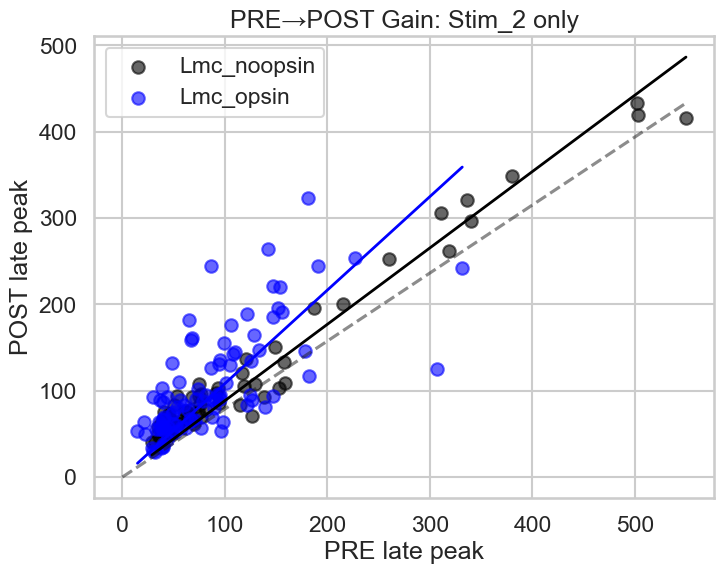


Model comparison:

         label  n_points  slope_mul  \
0  Stim_2 only       156   0.953288   

                                 slope_mul_CI      mul_AIC  intercept_add  \
0  [[0.9030184433377171, 1.0035580197688971]]  1617.313811      10.546784   

                            intercept_add_CI      add_AIC  
0  [[3.8766995451795125, 17.21686922290871]]  1611.146014  


ANALYSIS FOR: Averaged (Stim_2 + Stim_3_4)



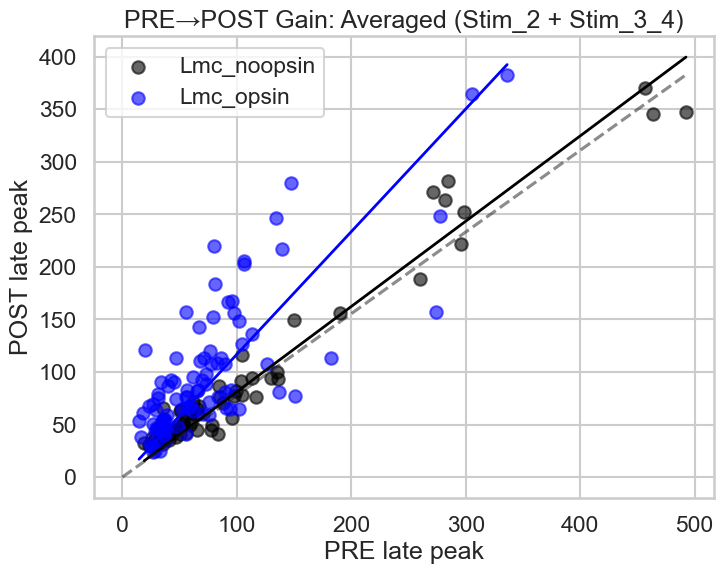


Model comparison:

                          label  n_points  slope_mul  \
0  Averaged (Stim_2 + Stim_3_4)       156   0.940053   

                                 slope_mul_CI      mul_AIC  intercept_add  \
0  [[0.8844590388471151, 0.9956467026656116]]  1614.594362       8.461579   

                             intercept_add_CI     add_AIC  
0  [[1.7523792934660953, 15.170777944542817]]  1612.97029  


FINAL MODEL SUMMARY ACROSS ALL ANALYSIS VERSIONS:


,label,n_points,slope_mul,slope_mul_CI,mul_AIC,intercept_add,intercept_add_CI,add_AIC
0,Stim_3_4 only,156,0.960470,"[[0.897809920432671, 1.0231308422944103]]",1664.938135,12.477516,"[[4.7627218503962645, 20.192310418412436]]",1656.544274
1,Stim_2 only,156,0.953288,"[[0.9030184433377171, 1.0035580197688971]]",1617.313811,10.546784,"[[3.8766995451795125, 17.21686922290871]]",1611.146014
2,Averaged (Stim_2 + Stim_3_4),156,0.940053,"[[0.8844590388471151, 0.9956467026656116]]",1614.594362,8.461579,"[[1.7523792934660953, 15.170777944542817]]",1612.970290


In [95]:
# ============================================================
#  INTERACTION & SLOPE ANALYSIS FOR ALL THREE MODULATION DEFINITIONS
#  - Stim_3_4 only
#  - Stim_2 only
#  - Averaged Stim2 + Stim3_4
# ============================================================

%pip install statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.set(style="whitegrid", context="talk")

datasets = {
    "Stim_3_4 only": df_mod_stim34,
    "Stim_2 only": df_mod_stim2,
    "Averaged (Stim_2 + Stim_3_4)": df_mod_avg
}

results_list = []


def fit_gain_model(df, label):
    """Fit multiplicative vs additive model, extract slope and intercept."""

    PRE = df["pre_peak"].values
    POST = df["post_peak"].values

    # --- Multiplicative model: POST = a * PRE
    X_mul = PRE.reshape(-1,1)
    mul_model = sm.OLS(POST, X_mul).fit()
    
    # --- Additive model: POST = PRE + k (equiv POST-PRE = k)
    X_add = np.ones_like(PRE)
    add_model = sm.OLS(POST - PRE, X_add).fit()
    
    return {
        "label": label,
        "n_points": len(df),
        "slope_mul": mul_model.params[0],
        "slope_mul_CI": mul_model.conf_int().tolist(),
        "mul_AIC": mul_model.aic,
        "intercept_add": add_model.params[0],
        "intercept_add_CI": add_model.conf_int().tolist(),
        "add_AIC": add_model.aic,
    }


def plot_gain(df, title):
    """Scatter PRE→POST with regression fits per group."""

    plt.figure(figsize=(8,6))
    for group, color in zip(["Lmc_noopsin","Lmc_opsin"], ["black","blue"]):
        df_g = df[df.group==group]
        plt.scatter(df_g["pre_peak"], df_g["post_peak"], alpha=0.6, label=group, color=color)

        # fit slope
        X = df_g["pre_peak"].values.reshape(-1,1)
        y = df_g["post_peak"].values
        model = sm.OLS(y, X).fit()
        xx = np.linspace(X.min(), X.max(), 100)
        plt.plot(xx, model.predict(xx.reshape(-1,1)), color=color, linewidth=2)

    plt.plot([0, max(df["pre_peak"])], [0, max(df["post_peak"])], 'k--', alpha=0.5)
    plt.xlabel("PRE late peak")
    plt.ylabel("POST late peak")
    plt.title(title)
    plt.legend()
    plt.show()


# ============================================================
# RUN ANALYSIS FOR ALL THREE DATASETS
# ============================================================

for name, df in datasets.items():

    print("\n\n===============================================")
    print(f"ANALYSIS FOR: {name}")
    print("===============================================\n")

    # 1 — Scatter + fitted slope per group
    plot_gain(df, f"PRE→POST Gain: {name}")

    # 2 — Fit models and extract slope + model comparison
    res = fit_gain_model(df, name)
    results_list.append(res)

    print("\nModel comparison:\n")
    print(pd.DataFrame([res]))


# Combine model results into a single table
df_models = pd.DataFrame(results_list)
print("\n\nFINAL MODEL SUMMARY ACROSS ALL ANALYSIS VERSIONS:")
display(df_models)

In [97]:
from pathlib import Path
import numpy as np
spk = Path("/Volumes/MannySSD/lmc_project_v2_MINIMAL/LED/SpikeStuff/Lmc_opsin/lmc_ch_2_3093_rec1/temp_wh_spike_times.npy")
if spk.exists():
    data = np.load(spk, allow_pickle=True)
    if hasattr(data, 'files'):
        print(data.files)  # For .npz files
    else:
        print("Loaded .npy file, shape:", data.shape)
        print("First few entries:", data[:5])
else:
    print("No spike_times file here")

Loaded .npy file, shape: (1408131,)
First few entries: [(0.0035,  5) (0.0035, 13) (0.0036, 13) (0.0046, 13) (0.0049, 31)]


Saved trial-level counts to /Volumes/MannySSD/PSTH_replot_from_saved_dicts/run15/trial_counts.csv


""
